In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'
import matplotlib.colors as colors
import cmocean.cm as cmo
from glob import glob
# import xgcm

In [2]:
from dask.distributed import Client
client = Client()
client

<Client: 'tcp://127.0.0.1:34405' processes=4 threads=4, memory=31.34 GiB>

In [3]:
import datetime
import nc_time_axis

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cartopy
import matplotlib.path as mpath

In [5]:
GRIDT_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-T_clim/*gridTclim.nc"
ICEMOD_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-icemod_clim/*icemodclim.nc"
NSQUARE_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-Nsquared/clim/*5d_Nsquared.nc"
EKE_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-EKE/clim/*EKEclim.nc"
MKE_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-MKE/clim/*MKE.nc"
SHEAR_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-shear/clim/*shear.nc"

In [6]:
GRIDT_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-T_clim/*gridTclim.nc"
ICEMOD_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-icemod_clim/*icemodclim.nc"
NSQUARE_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-Nsquared/clim/*5d_Nsquared.nc"
EKE_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-EKE/clim/*EKEclim.nc"
MKE_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-MKE/clim/*MKE.nc"
SHEAR_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-shear/clim/*shear.nc"

In [7]:
def prepro(ds):
    return ds.isel(y=slice(800, None))

In [8]:
grid_files = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_hgr.nc"
coords_file = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/coordinates_CREG12_lbclnk_noz_vh20160930.nc"
mask_file= "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mask.nc"


In [9]:
grid = xr.open_mfdataset(grid_files, parallel=True, preprocess=prepro)
coords = xr.open_mfdataset(coords_file, parallel=True, preprocess=prepro)
mask = xr.open_mfdataset(mask_file, parallel=True, preprocess=prepro)

# Density

In [10]:
GRIDT_REF = xr.open_mfdataset(GRIDT_data_filesREF, preprocess=prepro, parallel=True)

GRIDT_REF = GRIDT_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [11]:
GRIDT_FUT = xr.open_mfdataset(GRIDT_data_filesFUT, preprocess=prepro, parallel=True)

GRIDT_FUT = GRIDT_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [12]:
from utils import *

In [13]:
x_0 = np.linspace(-150,-150,400)
y_0 = np.linspace(70,90,400)

x_1 = np.linspace(0,0,300)
y_1 = np.linspace(90,75,300)

x_i = np.hstack((x_0,x_1))
y_i = np.hstack((y_0,y_1))

x_i2 = np.linspace(120,120,400)
y_i2 = np.linspace(90,73,400)

In [14]:
transects = [[x_i,y_i],[x_i2,y_i2]]

In [15]:
def extract_transects(transects_coords, ds_ref, ds_fut , var=None, outfile="output_{0}.nc"):
    transects_data = []
    for counter, transect in enumerate(transects_coords):
        # print(counter,transect[0])
        
        x = transect[0]
        y = transect[1]
        if len(x) != len(y):
            raise ValueError("Lenght of transect x and y should be identical")
            
        index_y ,index_x = extract_transect(x,y,ds_ref)
        
        ds_xi = xr.DataArray(index_x.ravel(), dims=["x_points"])
        ds_yi = xr.DataArray(index_y.ravel(), dims=["y_points"])
        
        ds_REF = ds_ref[var].assign_coords({"xt{0}".format(counter):ds_ref.x,"yt{0}".format(counter):ds_ref.y}).to_dataset().swap_dims({"x":"xt{0}".format(counter),"y":"yt{0}".format(counter)})
        transect_REF = ds_REF.isel({"xt{0}".format(counter):ds_xi,"yt{0}".format(counter):ds_yi}).rename({var:var+"_ref_t{0}".format(counter)})
        transect_REF = transect_REF.rename({"x_points":"x_points"+"_t{0}".format(counter),"y_points":"y_points"+"_t{0}".format(counter)})

        ds_FUT = ds_fut[var].assign_coords({"xt{0}".format(counter):ds_fut.x,"yt{0}".format(counter):ds_fut.y}).to_dataset().swap_dims({"x":"xt{0}".format(counter),"y":"yt{0}".format(counter)})
        transect_FUT = ds_FUT.isel({"xt{0}".format(counter):ds_xi,"yt{0}".format(counter):ds_yi}).rename({var:var+"_fut_t{0}".format(counter)})
        transect_FUT = transect_FUT.rename({"x_points":"x_points"+"_t{0}".format(counter),"y_points":"y_points"+"_t{0}".format(counter)})

        # transect_FUT = ds_fut[var].assign_coords({"xt{0}".format(counter):ds_fut.x,"yt{0}".format(counter):ds_fut.y})
        # transect_REF.isel({"xt{0}".format(counter):ds_xi,"yt{0}".format(counter):ds_yi}).rename(var+"_fut_t{0}".format(counter))
        
        diag = xr.DataArray(np.arange(len(x)), dims="diag")
        diag_transect_REF = transect_REF.isel({"x_points"+"_t{0}".format(counter):diag, "y_points"+"_t{0}".format(counter):diag})
        diag_transect_FUT = transect_FUT.isel({"x_points"+"_t{0}".format(counter):diag, "y_points"+"_t{0}".format(counter):diag})
        
        transects_data.append([diag_transect_REF, diag_transect_FUT])
    
    transect_dataset = { "transect_{0}".format(ii) : xr.merge(transects_data[ii]) for ii in range(len(transects_data))}
    
    print("Storing data")
    
    [item.to_netcdf(outfile.format(key)) for key,item in transect_dataset.items()]
    
    return transect_dataset


In [16]:
transects_data = extract_transects(transects,GRIDT_REF,GRIDT_FUT,'rhop_sig0','/data0/project/drakkar/USERS/jrieck/transects/density_{0}.nc')

Storing data


In [17]:
data2plot_rho_t0 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/density_transect_0.nc')
data2plot_rho_t1 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/density_transect_1.nc')

In [18]:
data2plot_REF_rho  = data2plot_rho_t0.rhop_sig0_ref_t0.groupby('time_counter.season').mean().compute()
data2plot_FUT_rho  = data2plot_rho_t0.rhop_sig0_fut_t0.groupby('time_counter.season').mean().compute()

In [19]:
data2plot_REF_rho_t0  = data2plot_REF_rho.isel(diag=slice(0,400))
data2plot_FUT_rho_t0  = data2plot_FUT_rho.isel(diag=slice(0,400))

In [20]:
data2plot_REF_rho_t1  = data2plot_REF_rho.isel(diag=slice(400,None))
data2plot_FUT_rho_t1  = data2plot_FUT_rho.isel(diag=slice(400,None))

In [21]:
data2plot_REF_rho_t2  = data2plot_rho_t1.rhop_sig0_ref_t1.groupby('time_counter.season').mean().compute()
data2plot_FUT_rho_t2  = data2plot_rho_t1.rhop_sig0_fut_t1.groupby('time_counter.season').mean().compute()

In [22]:
def create_extra_axis(ax,ds):
    ax1_t = ax.twiny()
    ax1_t.spines["bottom"].set_position(("axes", -0.25))
    ax1_t.set_frame_on(True)
    ax1_t.patch.set_visible(False)
    ax1_t.xaxis.set_ticks_position("bottom")
    ax1_t.xaxis.set_label_position("bottom")

    ax1_t.plot(ds.diag*0,alpha=0)
    
    ax1_t.set_xlim(0,max(ds.diag))
    ax1_t.set_xticks(np.arange(0,max(ds.diag)-1,100))
    
    return ax1_t


def latitude_labels(ax,ds):
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [np.round(ds.nav_lat.isel(diag=int(label)).values) for label in labels]

    ax.set_xticklabels(labels)
    # ax.set_xlabel('Latitude')
    
    
def plot_transects(ds=None,ds_cf=None,ds_ice=None,contour=True, contourf=False, varname="",ylim=(0,500),figsize=(7,7),output="out.png", kwargs_plot=None):
    fig = plt.figure(figsize=(7, 7))

    ax1 = fig.add_subplot(3, 1, 1)
    ax1_1 = fig.add_axes([1, 0.95, 0.65, 0.2])
    ax1_2 = fig.add_axes([1, 0.6, 0.65, 0.2])
    
    ax2 = fig.add_subplot(3, 1, 3)
    ax2_1 = fig.add_axes([1, 0.22, 0.65, 0.2])
    ax2_2 = fig.add_axes([1, -0.13, 0.65, 0.2])
    
    axis = [ax1,ax1_1,ax1_2,ax2,ax2_1,ax2_2]

    ax1.set_title("REF")
    ax2.set_title("FUT")
    
    if ds and not contourf:
        data2plot_REF_t0 = ds['REF']["t0"]
        data2plot_REF_t1 = ds['REF']["t1"]
        data2plot_REF_t2 = ds['REF']["t2"]
        data2plot_FUT_t0 = ds['FUT']["t0"]
        data2plot_FUT_t1 = ds['FUT']["t1"]
        data2plot_FUT_t2 = ds['FUT']["t2"]
        
        cbar = data2plot_REF_t0.plot(x='diag', ax=ax1, **kwargs_plot, rasterized=True)
        data2plot_REF_t1.plot(x='diag', ax=ax1_1, **kwargs_plot, rasterized=True)
        data2plot_REF_t2.plot(x='diag', ax=ax1_2, **kwargs_plot, rasterized=True)
        data2plot_FUT_t0.plot(x='diag', ax=ax2, **kwargs_plot, rasterized=True)
        data2plot_FUT_t1.plot(x='diag', ax=ax2_1, **kwargs_plot, rasterized=True)
        data2plot_FUT_t2.plot(x='diag', ax=ax2_2, **kwargs_plot, rasterized=True)
        
        cax = plt.axes((0.15, -0.05, 0.7, 0.03))
        cbar = plt.colorbar(cbar, cax=cax,orientation='horizontal')
        cbar.ax.tick_params(labelsize=12)
        
        cbar.set_label(varname)
    
    elif ds and contourf: 
        data2plot_REF_t0 = ds['REF']["t0"]
        data2plot_REF_t1 = ds['REF']["t1"]
        data2plot_REF_t2 = ds['REF']["t2"]
        data2plot_FUT_t0 = ds['FUT']["t0"]
        data2plot_FUT_t1 = ds['FUT']["t1"]
        data2plot_FUT_t2 = ds['FUT']["t2"]
        
        cbar = data2plot_REF_t0.plot.contourf(x='diag', ax=ax1, **kwargs_plot)
        data2plot_REF_t1.plot.contourf(x='diag', ax=ax1_1, **kwargs_plot)
        data2plot_REF_t2.plot.contourf(x='diag', ax=ax1_2, **kwargs_plot)
        data2plot_FUT_t0.plot.contourf(x='diag', ax=ax2, **kwargs_plot)
        data2plot_FUT_t1.plot.contourf(x='diag', ax=ax2_1, **kwargs_plot)
        data2plot_FUT_t2.plot.contourf(x='diag', ax=ax2_2, **kwargs_plot)
        
        cax = plt.axes((0.15, -0.05, 0.7, 0.03))
        cbar = plt.colorbar(cbar, cax=cax,orientation='horizontal')
        cbar.ax.tick_params(labelsize=12)
        
        cbar.set_label(varname)
    
    if contour and ds_cf:
        # Reference run
        data2plot_REF_rho_t0 = ds_cf['REF']["t0"]
        data2plot_REF_rho_t1 = ds_cf['REF']["t1"]
        data2plot_REF_rho_t2 = ds_cf['REF']["t2"]
        data2plot_FUT_rho_t0 = ds_cf['FUT']["t0"]
        data2plot_FUT_rho_t1 = ds_cf['FUT']["t1"]
        data2plot_FUT_rho_t2 = ds_cf['FUT']["t2"]
        
        cs = data2plot_REF_rho_t0.where(data2plot_REF_rho_t0> 1000).plot.contour(x='diag', ax=ax1,vmin=1020,vmax=1030,cmap=cmo.dense,levels=[1024,1026,1027])
        ax1.clabel(cs, inline=1, fontsize=10)

        cs = data2plot_REF_rho_t1.where(data2plot_REF_rho_t1> 1000).plot.contour(x='diag', ax=ax1_1,vmin=1020,vmax=1030,cmap=cmo.dense,levels=[1024,1026,1027])
        ax1_1.clabel(cs, inline=1, fontsize=10)
    
        cs = data2plot_REF_rho_t2.where(data2plot_REF_rho_t2> 1000).plot.contour(x='diag', ax=ax1_2,vmin=1020,vmax=1030,cmap=cmo.dense,levels=[1024,1026,1027])
        ax1_2.clabel(cs, inline=1, fontsize=10)

        # Future run
        cs = data2plot_FUT_rho_t0.where(data2plot_FUT_rho_t0> 1000).plot.contour(x='diag',ax=ax2,vmin=1020,vmax=1030,cmap=cmo.dense,levels=[1024,1026,1027])
        ax2.clabel(cs, inline=1, fontsize=10)

        cs = data2plot_FUT_rho_t1.where(data2plot_FUT_rho_t1> 1000).plot.contour(x='diag',ax=ax2_1,vmin=1020,vmax=1030,cmap=cmo.dense,levels=[1024,1026,1027])
        ax2_1.clabel(cs, inline=1, fontsize=10)

        cs = data2plot_FUT_rho_t2.where(data2plot_FUT_rho_t2> 1000).plot.contour(x='diag',ax=ax2_2,vmin=1020,vmax=1030,cmap=cmo.dense,levels=[1024,1026,1027])
        ax2_2.clabel(cs, inline=1, fontsize=10)

    if ds_ice:
        counter=0
        for key, items in ds_ice.items():
            for key1,item in items.items():
                data2plot = item
                if counter==3:
                    fix_pos= -0.043
                else:
                    fix_pos=0
                
                ice_ax = fig.add_axes([axis[counter].get_position().x0,axis[counter].get_position().y1+fix_pos,axis[counter].get_position().width,0.05])
                ice_ax.fill_between(data2plot.diag,data2plot*0,data2plot,alpha=0.5)
                ice_ax.grid()
                ice_ax.set_ylim((0,3))
                ice_ax.set_xlim((0,max(data2plot.diag)))
                ice_ax.xaxis.set_ticklabels([])
                counter+=1
    
    # Style of plots    
    [ax.set_ylim(*ylim) for ax in axis]

    [ax.invert_yaxis() for ax in axis]

    [ax.set_xlabel('') for ax in axis]

    [ax.set_ylabel('Depth [m]') for ax in axis]

    ax1_t = create_extra_axis(ax1,data2plot_REF_rho_t0)
    ax2_t = create_extra_axis(ax2,data2plot_FUT_rho_t0)

    ax1_1_t = create_extra_axis(ax1_1,data2plot_REF_rho_t1)
    ax1_2_t = create_extra_axis(ax1_2,data2plot_FUT_rho_t2)

    ax2_1_t = create_extra_axis(ax2_1,data2plot_REF_rho_t1)
    ax2_2_t = create_extra_axis(ax2_2,data2plot_FUT_rho_t2)
    
    
    fig.canvas.draw()

    axis_t = [ax1_t,ax1_1_t,ax1_2_t,ax2_t,ax2_1_t,ax2_2_t]

    latitude_labels(ax1_t,data2plot_REF_rho_t0)
    latitude_labels(ax2_t,data2plot_REF_rho_t0)

    latitude_labels(ax1_1_t,data2plot_REF_rho_t1)
    latitude_labels(ax1_2_t,data2plot_REF_rho_t2)

    latitude_labels(ax2_1_t,data2plot_FUT_rho_t1)
    latitude_labels(ax2_2_t,data2plot_FUT_rho_t2)
    
    t = fig.text(0.4, 0.95, 'REF simulation', fontsize=16, weight=1000, va='center')
    t = fig.text(0.4, 0.36, 'FUT simulation', fontsize=16, weight=1000, va='center')
    
    plt.subplots_adjust(hspace=0.6)
    plt.savefig(output, bbox_inches='tight')
    
def plot_transects_diff(ds=None,ds_cf=None,ds_ice=None,contour=True, contourf=False, varname="",ylim=(0,500),figsize=(7,7),output="out.png", kwargs_plot=None):
    fig = plt.figure(figsize=(7, 7))

    ax1 = fig.add_subplot(3, 1, 2)
    ax1_1 = fig.add_axes([1, 0.6, 0.65, 0.2])
    ax1_2 = fig.add_axes([1, 0.2, 0.65, 0.2])

    axis = [ax1,ax1_1,ax1_2]
    
    if ds and not contourf:
        data2plot_REF_t0 = ds['REF']["t0"]
        data2plot_REF_t1 = ds['REF']["t1"]
        data2plot_REF_t2 = ds['REF']["t2"]
        data2plot_FUT_t0 = ds['FUT']["t0"]
        data2plot_FUT_t1 = ds['FUT']["t1"]
        data2plot_FUT_t2 = ds['FUT']["t2"]
        
        cbar = (data2plot_FUT_t0 - data2plot_REF_t0).plot(x='diag', ax=ax1, **kwargs_plot, rasterized=True)
        (data2plot_FUT_t1 - data2plot_REF_t1).plot(x='diag', ax=ax1_1, **kwargs_plot, rasterized=True)
        (data2plot_FUT_t2 - data2plot_REF_t2).plot(x='diag', ax=ax1_2, **kwargs_plot, rasterized=True)
                
        cax = plt.axes((0.15, 0.25, 0.7, 0.03))
        cbar = plt.colorbar(cbar, cax=cax,orientation='horizontal')
        cbar.ax.tick_params(labelsize=12)
        cbar.ax.xaxis.get_major_locator().numticks = 5
        
        cbar.set_label(varname)
    
    elif ds and contourf: 
        data2plot_REF_t0 = ds['REF']["t0"]
        data2plot_REF_t1 = ds['REF']["t1"]
        data2plot_REF_t2 = ds['REF']["t2"]
        data2plot_FUT_t0 = ds['FUT']["t0"]
        data2plot_FUT_t1 = ds['FUT']["t1"]
        data2plot_FUT_t2 = ds['FUT']["t2"]
        
        cbar = (data2plot_FUT_t0 - data2plot_REF_t0).plot.contourf(x='diag', ax=ax1, **kwargs_plot)
        (data2plot_FUT_t1 - data2plot_REF_t1).plot.contourf(x='diag', ax=ax1_1, **kwargs_plot)
        (data2plot_FUT_t2 - data2plot_REF_t2).plot.contourf(x='diag', ax=ax1_2, **kwargs_plot)
        
        cax = plt.axes((0.15, 0.25, 0.7, 0.03))
        cbar = plt.colorbar(cbar, cax=cax,orientation='horizontal')
        cbar.ax.tick_params(labelsize=12)
        cbar.ax.xaxis.get_major_locator().numticks = 5
        
        cbar.set_label(varname)
    
    
    # Style of plots    
    [ax.set_ylim(*ylim) for ax in axis]

    [ax.invert_yaxis() for ax in axis]

    [ax.set_xlabel('') for ax in axis]

    [ax.set_ylabel('Depth [m]') for ax in axis]

    ax1_t = create_extra_axis(ax1,data2plot_REF_t0)
    ax1_1_t = create_extra_axis(ax1_1,data2plot_REF_t1)
    ax1_2_t = create_extra_axis(ax1_2,data2plot_REF_t2)

    fig.canvas.draw()

    axis_t = [ax1_t,ax1_1_t,ax1_2_t]

    latitude_labels(ax1_t,data2plot_REF_t0)
    latitude_labels(ax1_1_t,data2plot_REF_t1)
    latitude_labels(ax1_2_t,data2plot_REF_t2)
    
    t = fig.text(0.4, 0.65, 'DIFF (FUT-REF)', fontsize=16, weight=1000, va='center')
    
    plt.subplots_adjust(hspace=0.6)
    plt.savefig(output, bbox_inches='tight')
    

In [25]:
ds_cf = {"REF":{"t0":data2plot_REF_rho_t0.sel(season="DJF"),"t1":data2plot_REF_rho_t1.sel(season="DJF"),"t2":data2plot_REF_rho_t2.sel(season="DJF")},
         "FUT":{"t0":data2plot_FUT_rho_t0.sel(season="DJF"),"t1":data2plot_FUT_rho_t1.sel(season="DJF"),"t2":data2plot_FUT_rho_t2.sel(season="DJF")}}

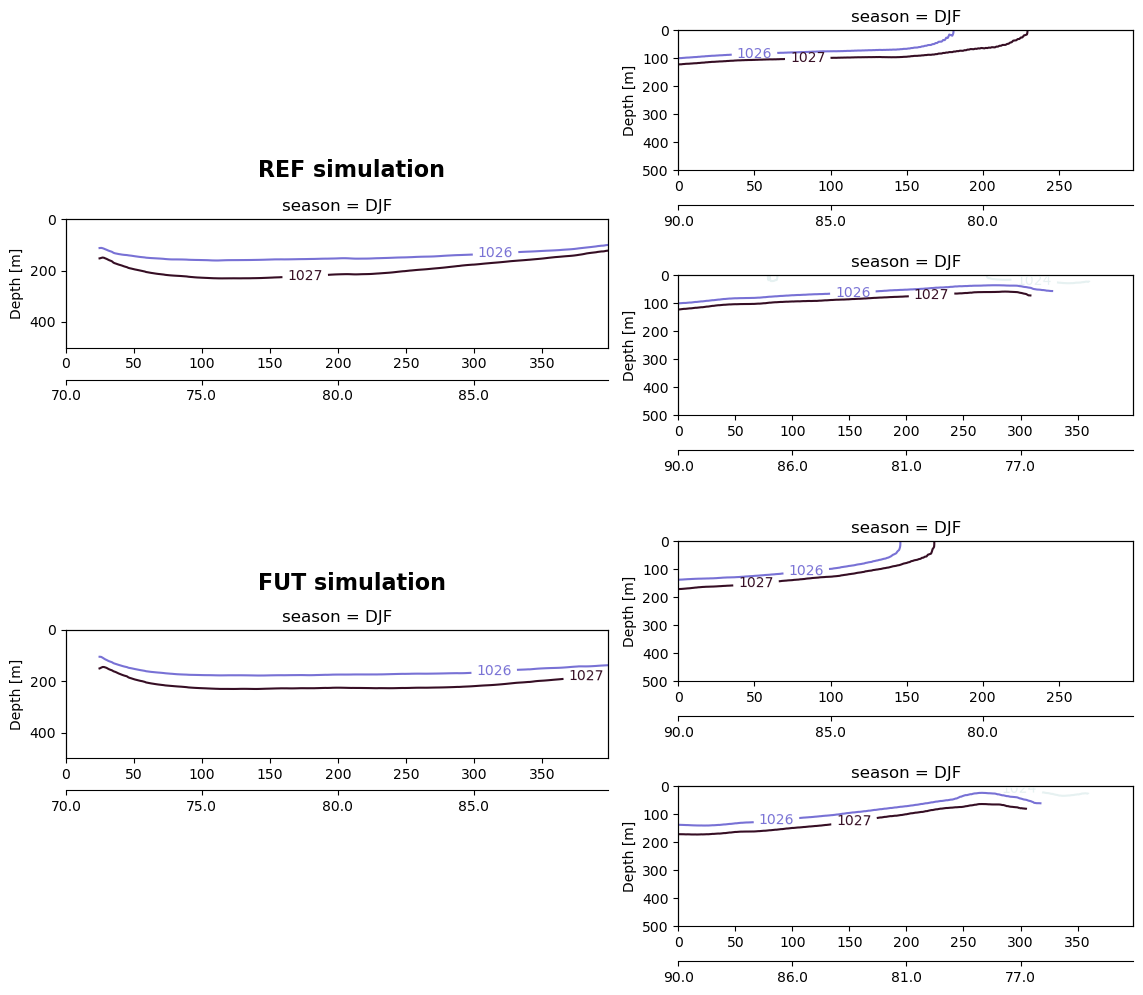

In [27]:
plot_transects(ds_cf=ds_cf,contour=True,ylim=(0,500),figsize=(7,7),output="winter_density_contours_gradient_REF_FUT.pdf")

In [28]:
ds_cf = {"REF":{"t0":data2plot_REF_rho_t0.sel(season="JJA"),"t1":data2plot_REF_rho_t1.sel(season="JJA"),"t2":data2plot_REF_rho_t2.sel(season="JJA")},
         "FUT":{"t0":data2plot_FUT_rho_t0.sel(season="JJA"),"t1":data2plot_FUT_rho_t1.sel(season="JJA"),"t2":data2plot_FUT_rho_t2.sel(season="JJA")}}

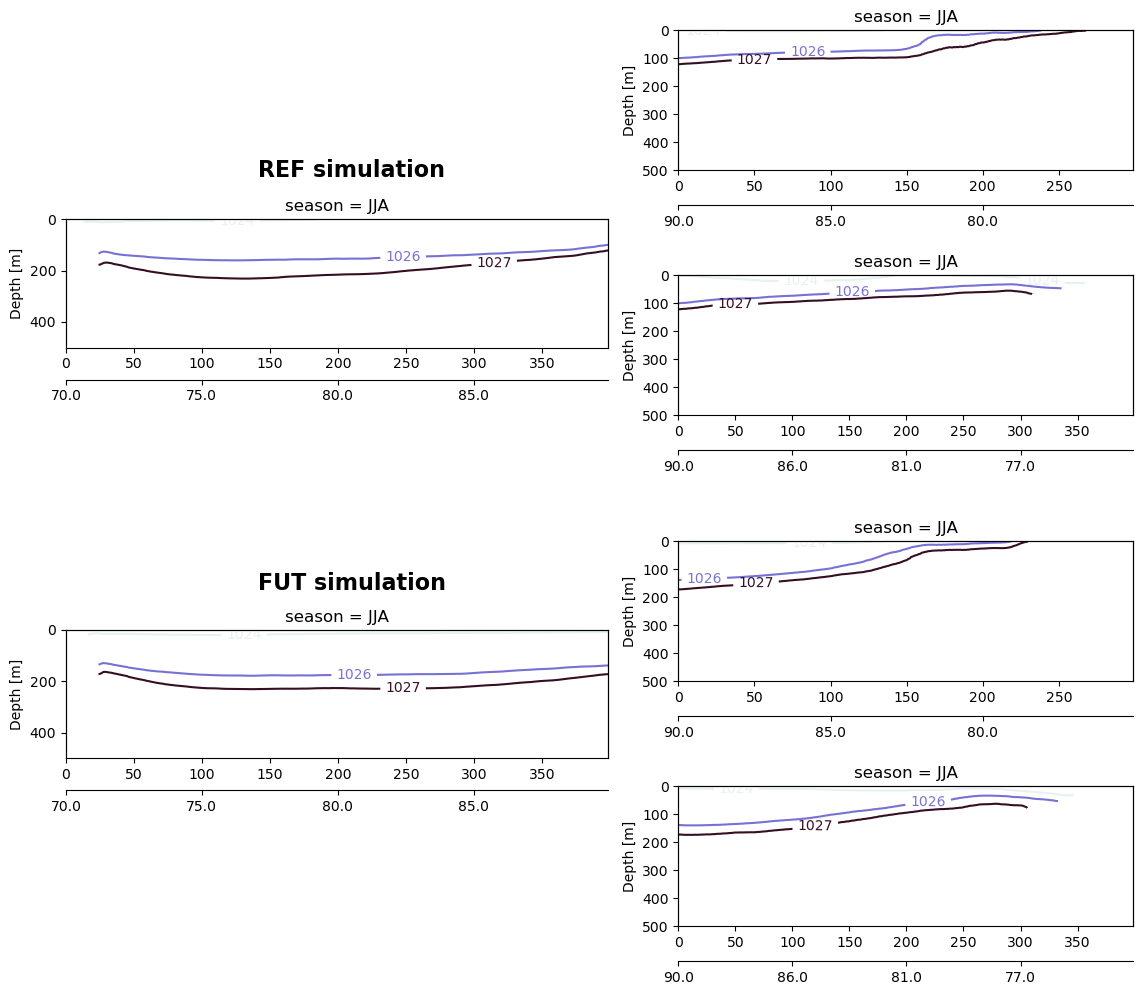

In [29]:
plot_transects(ds_cf=ds_cf,contour=True,ylim=(0,500),figsize=(7,7),output="summer_density_contours_gradient_REF_FUT.pdf")

# ICE

In [30]:
ICEMOD_REF = xr.open_mfdataset(ICEMOD_data_filesREF, preprocess=prepro, parallel=True)

ICEMOD_REF = ICEMOD_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [31]:
ICEMOD_FUT = xr.open_mfdataset(ICEMOD_data_filesFUT, preprocess=prepro, parallel=True)

ICEMOD_FUT = ICEMOD_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [32]:
# transects_data = extract_transects(transects,ICEMOD_REF,ICEMOD_FUT,'sithic','/data0/project/drakkar/USERS/jrieck/transects/sithic_{0}.nc')

In [33]:
data2plot_icethic_t0 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/sithic_transect_0.nc')
data2plot_icethic_t1 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/sithic_transect_1.nc')

In [34]:
data2plot_REF_icethick  = data2plot_icethic_t0.sithic_ref_t0.groupby('time_counter.season').mean().compute()
data2plot_FUT_icethick  = data2plot_icethic_t0.sithic_fut_t0.groupby('time_counter.season').mean().compute()

In [38]:
data2plot_REF_icethick_t0  = data2plot_REF_icethick.isel(diag=slice(0,400))
data2plot_FUT_icethick_t0  = data2plot_FUT_icethick.isel(diag=slice(0,400))
data2plot_REF_icethick_t1  = data2plot_REF_icethick.isel(diag=slice(400,None))
data2plot_FUT_icethick_t1  = data2plot_FUT_icethick.isel(diag=slice(400,None))

In [39]:
data2plot_REF_icethick_t2  = data2plot_icethic_t1.sithic_ref_t1.groupby('time_counter.season').mean().compute()
data2plot_FUT_icethick_t2  = data2plot_icethic_t1.sithic_fut_t1.groupby('time_counter.season').mean().compute()

In [40]:
ds_ice = {"REF":{"t0":data2plot_REF_icethick_t0.sel(season="DJF"),"t1":data2plot_REF_icethick_t1.sel(season="DJF"),"t2":data2plot_REF_icethick_t2.sel(season="DJF")},
         "FUT":{"t0":data2plot_FUT_icethick_t0.sel(season="DJF"),"t1":data2plot_FUT_icethick_t1.sel(season="DJF"),"t2":data2plot_FUT_icethick_t2.sel(season="DJF")}}

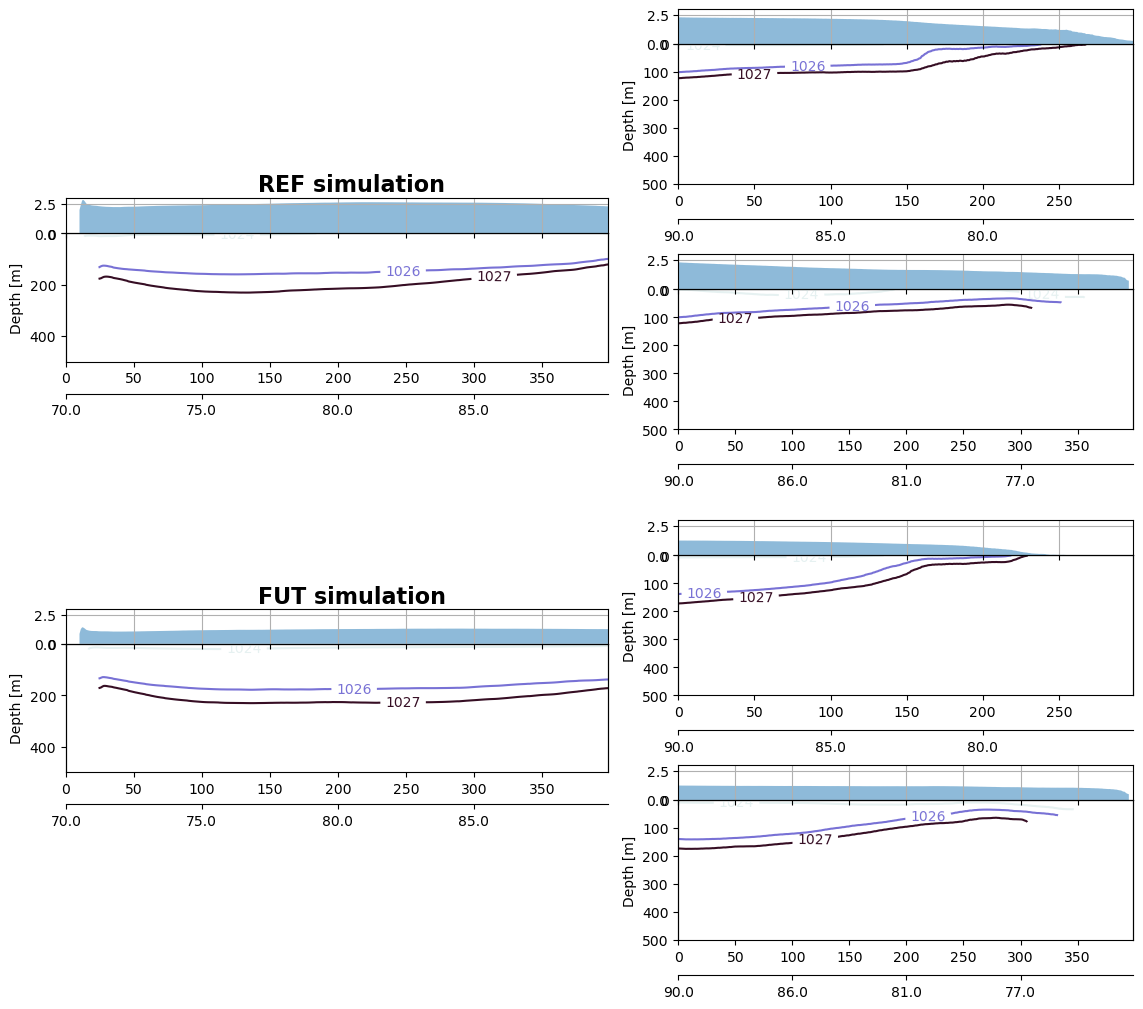

In [41]:
plot_transects(ds=0,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,ylim=(0,500),figsize=(7,7),output="winter_density_contours_gradient_ice_REF_FUT.pdf")

In [42]:
ds_ice = {"REF":{"t0":data2plot_REF_icethick_t0.sel(season="JJA"),"t1":data2plot_REF_icethick_t1.sel(season="JJA"),"t2":data2plot_REF_icethick_t2.sel(season="JJA")},
         "FUT":{"t0":data2plot_FUT_icethick_t0.sel(season="JJA"),"t1":data2plot_FUT_icethick_t1.sel(season="JJA"),"t2":data2plot_FUT_icethick_t2.sel(season="JJA")}}

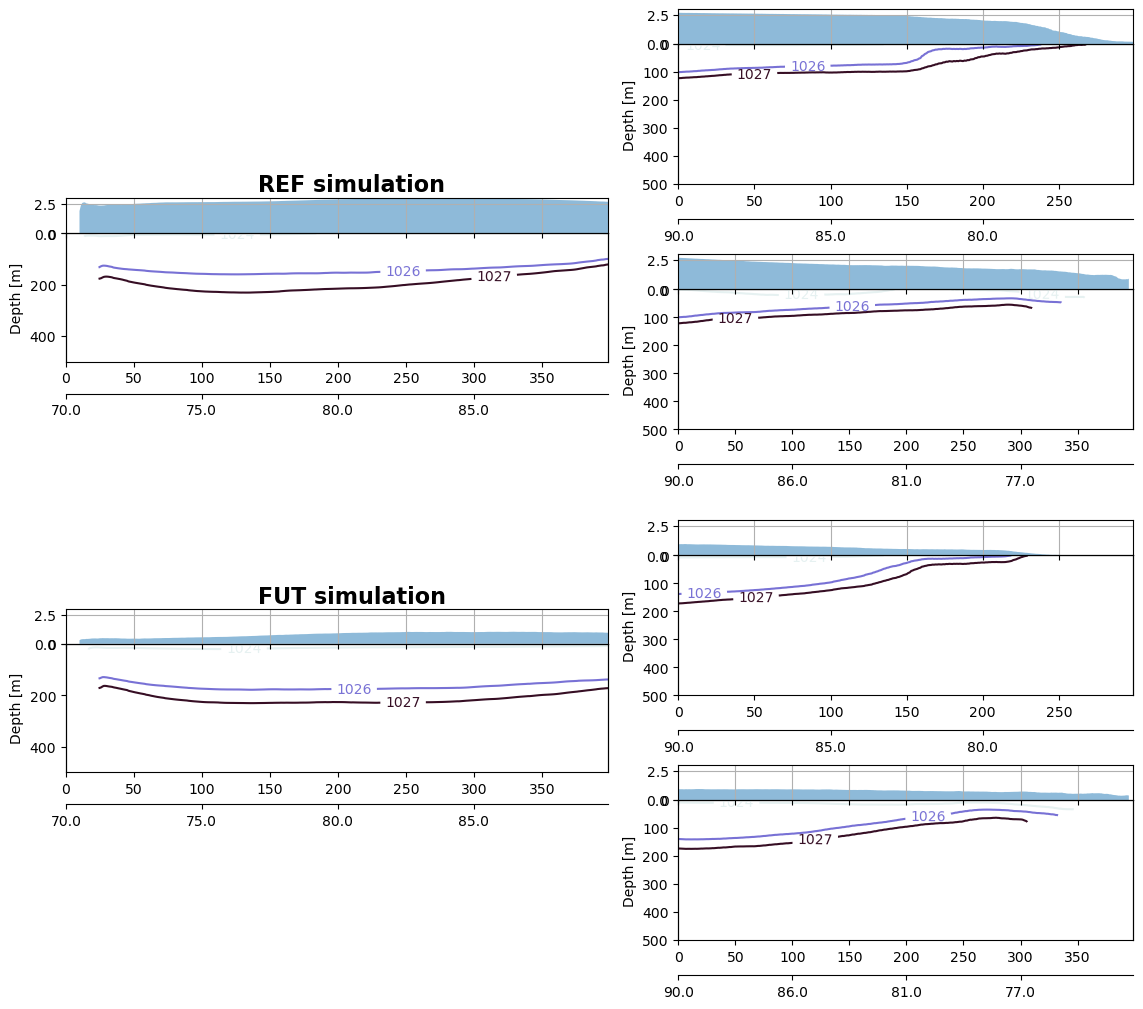

In [43]:
plot_transects(ds=0,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,ylim=(0,500),figsize=(7,7),output="summer_density_contours_gradient_ice_REF_FUT.pdf")

# Ice + density

In [53]:
ds_ice = {"REF":{"t0":data2plot_REF_icethick_t0.sel(season="DJF"),"t1":data2plot_REF_icethick_t1.sel(season="DJF"),"t2":data2plot_REF_icethick_t2.sel(season="DJF")},
         "FUT":{"t0":data2plot_FUT_icethick_t0.sel(season="DJF"),"t1":data2plot_FUT_icethick_t1.sel(season="DJF"),"t2":data2plot_FUT_icethick_t2.sel(season="DJF")}}

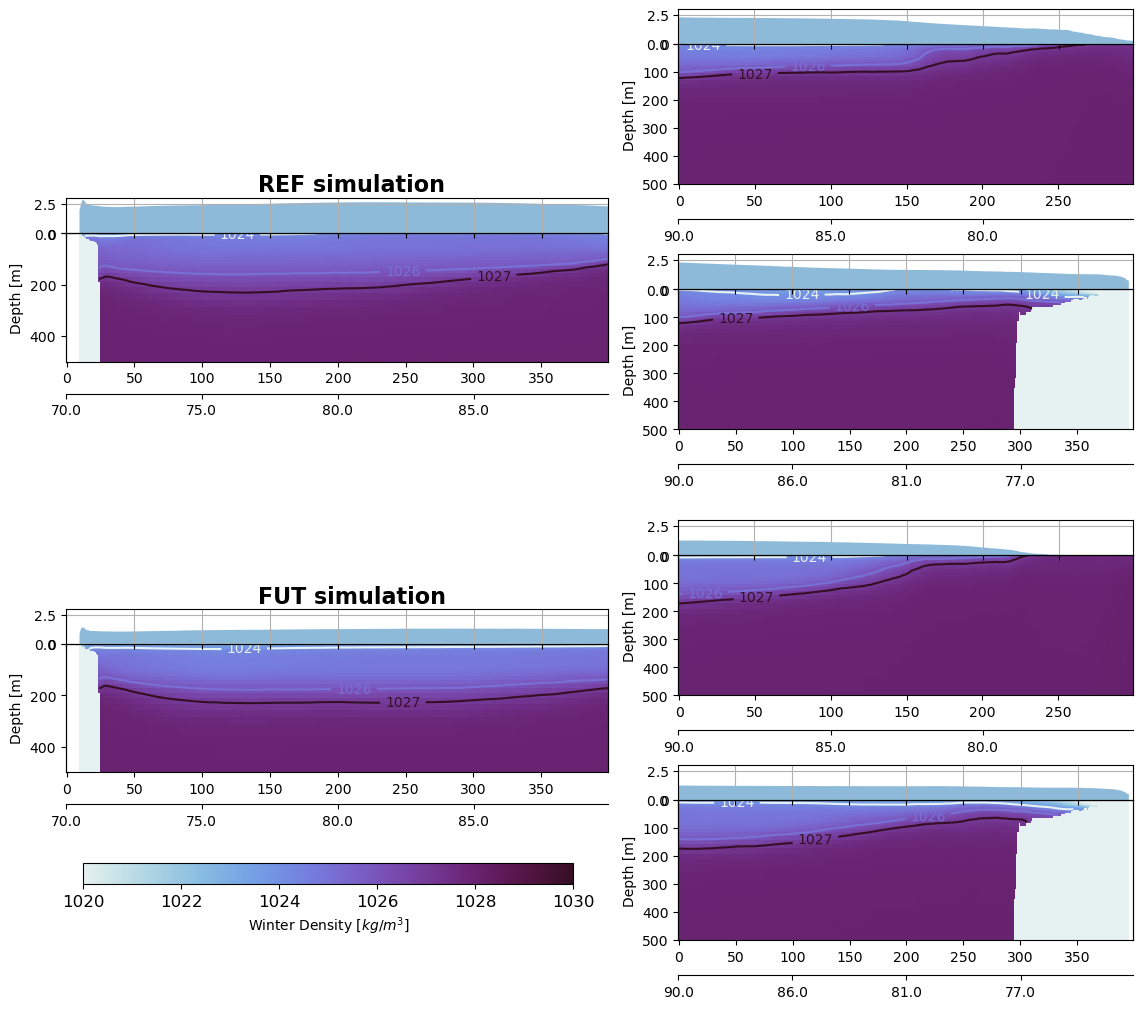

In [54]:
kwargs_plot = {'cmap':cmo.dense, 'vmin':1020, 'vmax':1030, 'add_colorbar':False}

plot_transects(ds=ds_cf,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Winter Density [$kg/m^3$]",ylim=(0,500),figsize=(7,7),output="./figures/winter_ICE_density_REF_FUT.pdf", kwargs_plot = kwargs_plot)

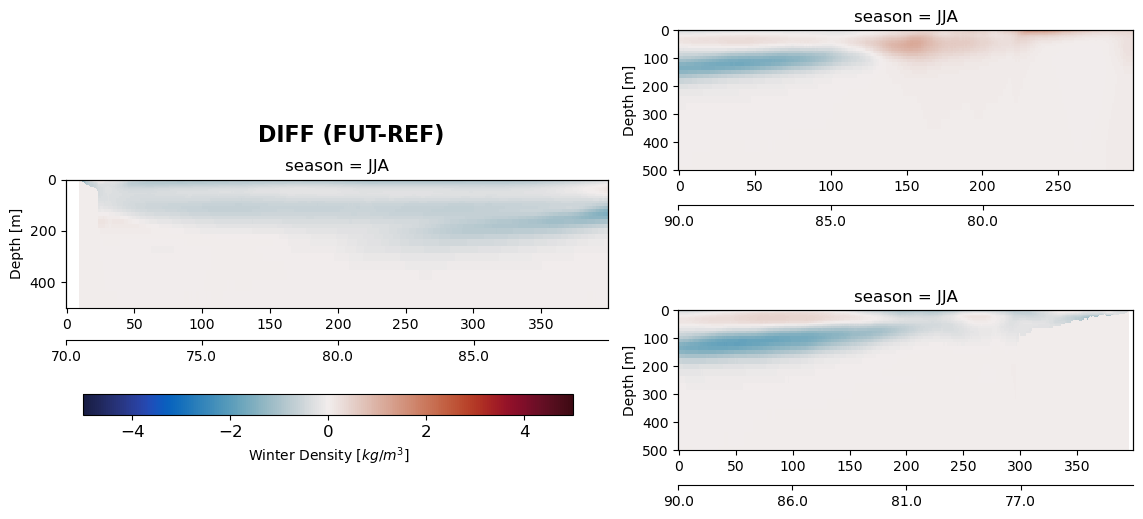

In [55]:
kwargs_plot = {'cmap':cmo.balance, 'vmin':-5, 'vmax':5, 'add_colorbar':False}

plot_transects_diff(ds=ds_cf,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Winter Density [$kg/m^3$]",ylim=(0,500),figsize=(7,7),output="./figures/winter_diff_ICE_density_REF_FUT.pdf", kwargs_plot = kwargs_plot)

In [48]:
ds_ice = {"REF":{"t0":data2plot_REF_icethick_t0.sel(season="JJA"),"t1":data2plot_REF_icethick_t1.sel(season="JJA"),"t2":data2plot_REF_icethick_t2.sel(season="JJA")},
         "FUT":{"t0":data2plot_FUT_icethick_t0.sel(season="JJA"),"t1":data2plot_FUT_icethick_t1.sel(season="JJA"),"t2":data2plot_FUT_icethick_t2.sel(season="JJA")}}

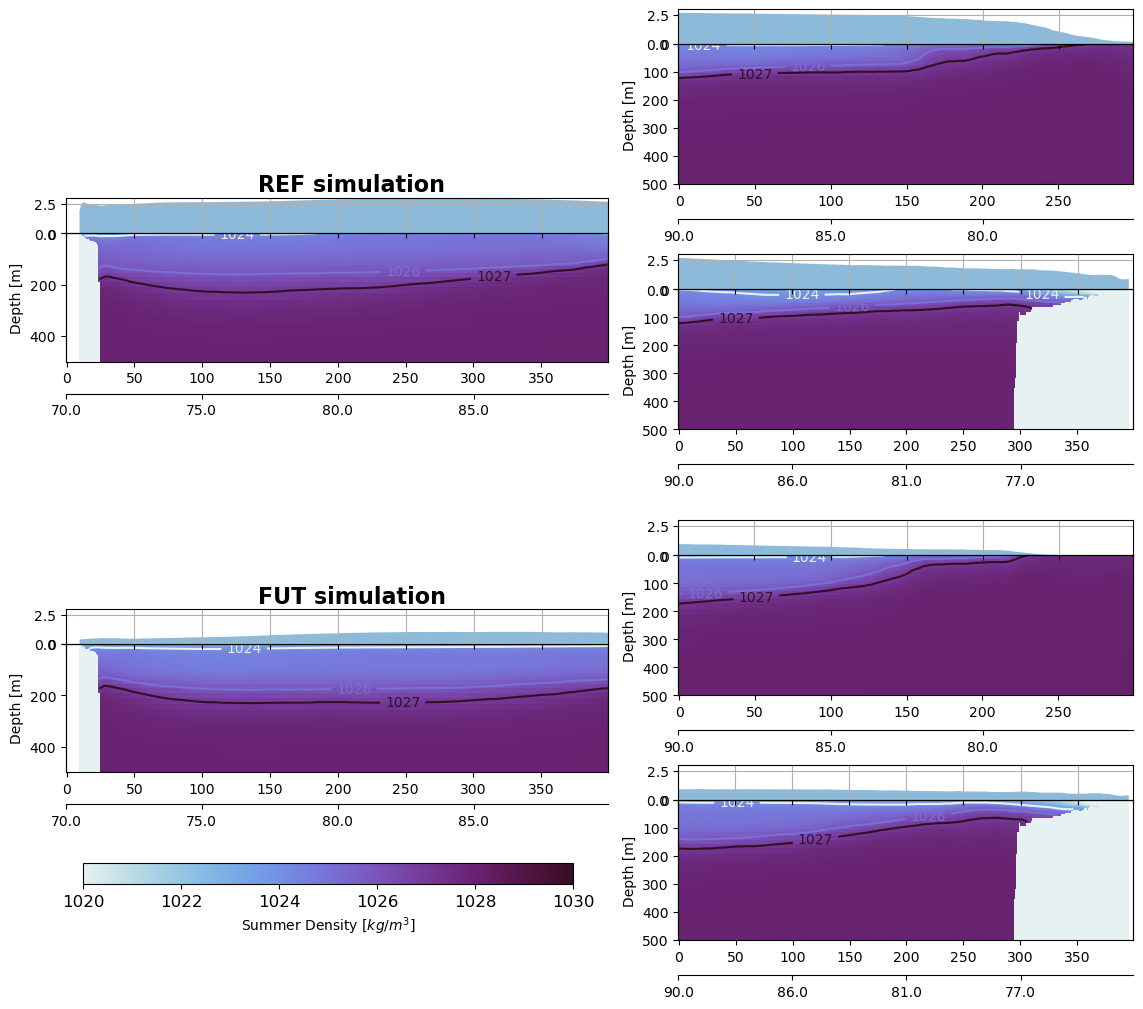

In [51]:
kwargs_plot = {'cmap':cmo.dense, 'vmin':1020, 'vmax':1030, 'add_colorbar':False}

plot_transects(ds=ds_cf,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Summer Density [$kg/m^3$]",ylim=(0,500),figsize=(7,7),output="./figures/summer_ICE_density_REF_FUT.pdf", kwargs_plot = kwargs_plot)

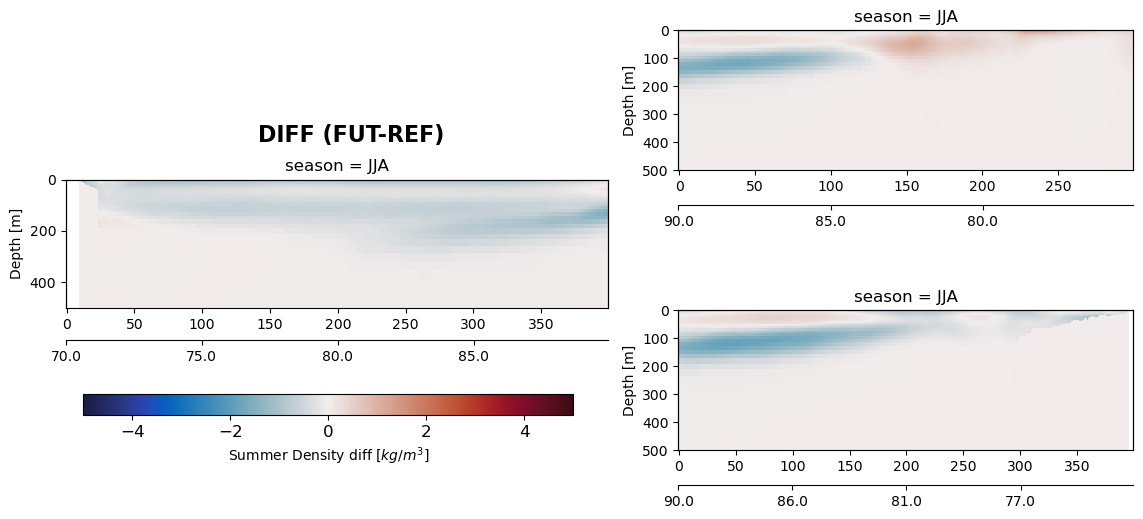

In [52]:
kwargs_plot = {'cmap':cmo.balance, 'vmin':-5, 'vmax':5, 'add_colorbar':False}

plot_transects_diff(ds=ds_cf,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Summer Density diff [$kg/m^3$]",ylim=(0,500),figsize=(7,7),output="./figures/summer_diff_ICE_density_REF_FUT.pdf", kwargs_plot = kwargs_plot)

# MKE, KE + ice + density

In [56]:
MKE_REF = xr.open_mfdataset(MKE_data_filesREF, preprocess=prepro, parallel=True)

MKE_REF = MKE_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [57]:
MKE_FUT = xr.open_mfdataset(MKE_data_filesFUT, preprocess=prepro, parallel=True)

MKE_FUT = MKE_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [58]:
EKE_REF = xr.open_mfdataset(EKE_data_filesREF, preprocess=prepro, parallel=True)

EKE_REF = EKE_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [59]:
EKE_FUT = xr.open_mfdataset(EKE_data_filesFUT, preprocess=prepro, parallel=True)

EKE_FUT = EKE_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [64]:
# transects_data = extract_transects(transects,MKE_REF,MKE_FUT,'vomke','/data0/project/drakkar/USERS/jrieck/transects/MKE_{0}.nc')

In [65]:
# transects_data = extract_transects(transects,EKE_REF,EKE_FUT,'voeke','/data0/project/drakkar/USERS/jrieck/transects/EKE_{0}.nc')

In [66]:
diag_transect_MKE_t0 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/MKE_transect_0.nc')
diag_transect_MKE_t1 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/MKE_transect_1.nc')

In [67]:
diag_transect_EKE_t0 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/EKE_transect_0.nc')
diag_transect_EKE_t1 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/EKE_transect_1.nc')

In [68]:
data2plot_REF_MKE = diag_transect_MKE_t0.vomke_ref_t0.groupby('time_counter.season').mean().compute()
data2plot_FUT_MKE = diag_transect_MKE_t0.vomke_fut_t0.groupby('time_counter.season').mean().compute()
data2plot_REF_EKE = diag_transect_EKE_t0.voeke_ref_t0.groupby('time_counter.season').mean().compute()
data2plot_FUT_EKE = diag_transect_EKE_t0.voeke_fut_t0.groupby('time_counter.season').mean().compute()

In [69]:
data2plot_REF_MKE_t0  = data2plot_REF_MKE.isel(diag=slice(0,400))
data2plot_FUT_MKE_t0  = data2plot_FUT_MKE.isel(diag=slice(0,400))
data2plot_REF_MKE_t1  = data2plot_REF_MKE.isel(diag=slice(400,None))
data2plot_FUT_MKE_t1  = data2plot_FUT_MKE.isel(diag=slice(400,None))

In [70]:
data2plot_REF_EKE_t0  = data2plot_REF_EKE.isel(diag=slice(0,400))
data2plot_FUT_EKE_t0  = data2plot_FUT_EKE.isel(diag=slice(0,400))
data2plot_REF_EKE_t1  = data2plot_REF_EKE.isel(diag=slice(400,None))
data2plot_FUT_EKE_t1  = data2plot_FUT_EKE.isel(diag=slice(400,None))

In [71]:
data2plot_REF_MKE_t2 = diag_transect_MKE_t1.vomke_ref_t1.groupby('time_counter.season').mean().compute()
data2plot_FUT_MKE_t2 = diag_transect_MKE_t1.vomke_fut_t1.groupby('time_counter.season').mean().compute()
data2plot_REF_EKE_t2 = diag_transect_EKE_t1.voeke_ref_t1.groupby('time_counter.season').mean().compute()
data2plot_FUT_EKE_t2 = diag_transect_EKE_t1.voeke_fut_t1.groupby('time_counter.season').mean().compute()

In [72]:
ds = {"REF":{"t0":data2plot_REF_MKE_t0.sel(season="DJF"),"t1":data2plot_REF_MKE_t1.sel(season="DJF"),"t2":data2plot_REF_MKE_t2.sel(season="DJF")},
      "FUT":{"t0":data2plot_FUT_MKE_t0.sel(season="DJF"),"t1":data2plot_FUT_MKE_t1.sel(season="DJF"),"t2":data2plot_FUT_MKE_t2.sel(season="DJF")}}

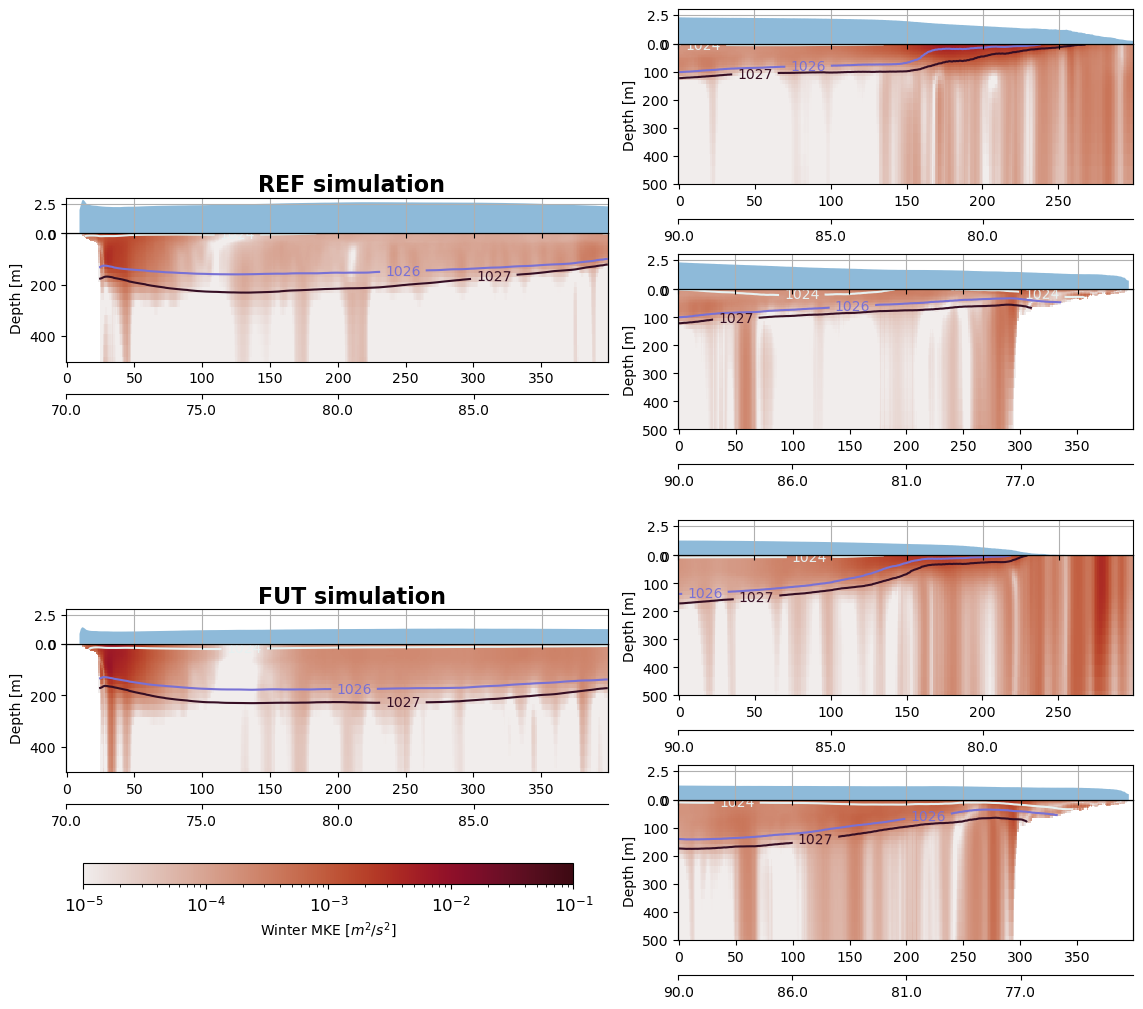

In [73]:
kwargs_plot = { 'cmap':cmo.amp, 'norm':colors.LogNorm(vmin=1e-5, vmax=1e-1), 'add_colorbar':False}

plot_transects(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Winter MKE [$m^2/s^2$]",ylim=(0,500),figsize=(7,7),output="./figures/winter_ICE_MKE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

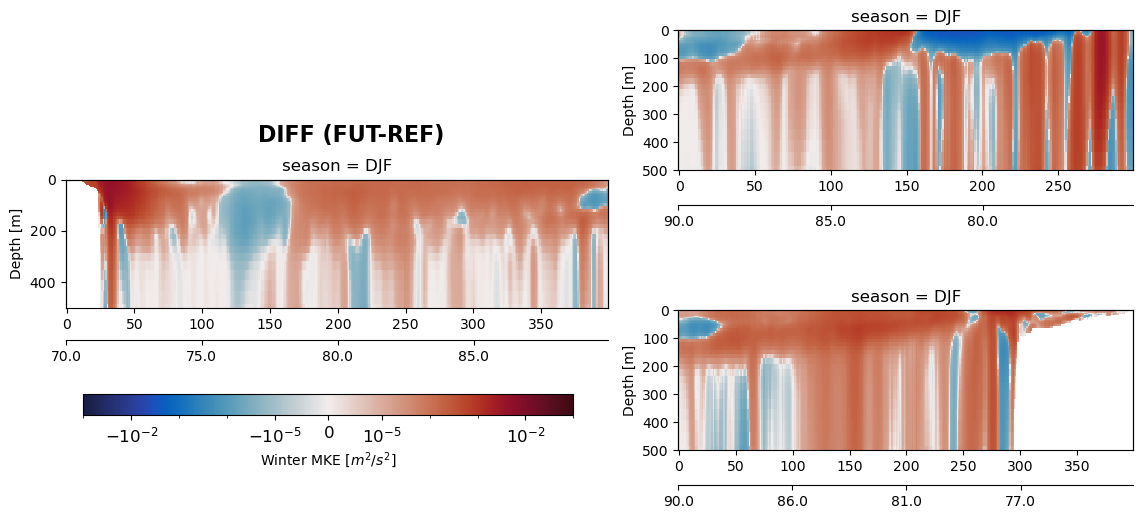

In [74]:
kwargs_plot = { 'cmap':cmo.balance, 'norm':colors.SymLogNorm(linthresh=1e-5, vmin=-1e-1, vmax=1e-1), 'add_colorbar':False}

plot_transects_diff(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Winter MKE [$m^2/s^2$]",ylim=(0,500),figsize=(7,7),output="./figures/winter_diff_ICE_MKE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

In [76]:
ds = {"REF":{"t0":data2plot_REF_MKE_t0.sel(season="JJA"),"t1":data2plot_REF_MKE_t1.sel(season="JJA"),"t2":data2plot_REF_MKE_t2.sel(season="JJA")},
      "FUT":{"t0":data2plot_FUT_MKE_t0.sel(season="JJA"),"t1":data2plot_FUT_MKE_t1.sel(season="JJA"),"t2":data2plot_FUT_MKE_t2.sel(season="JJA")}}

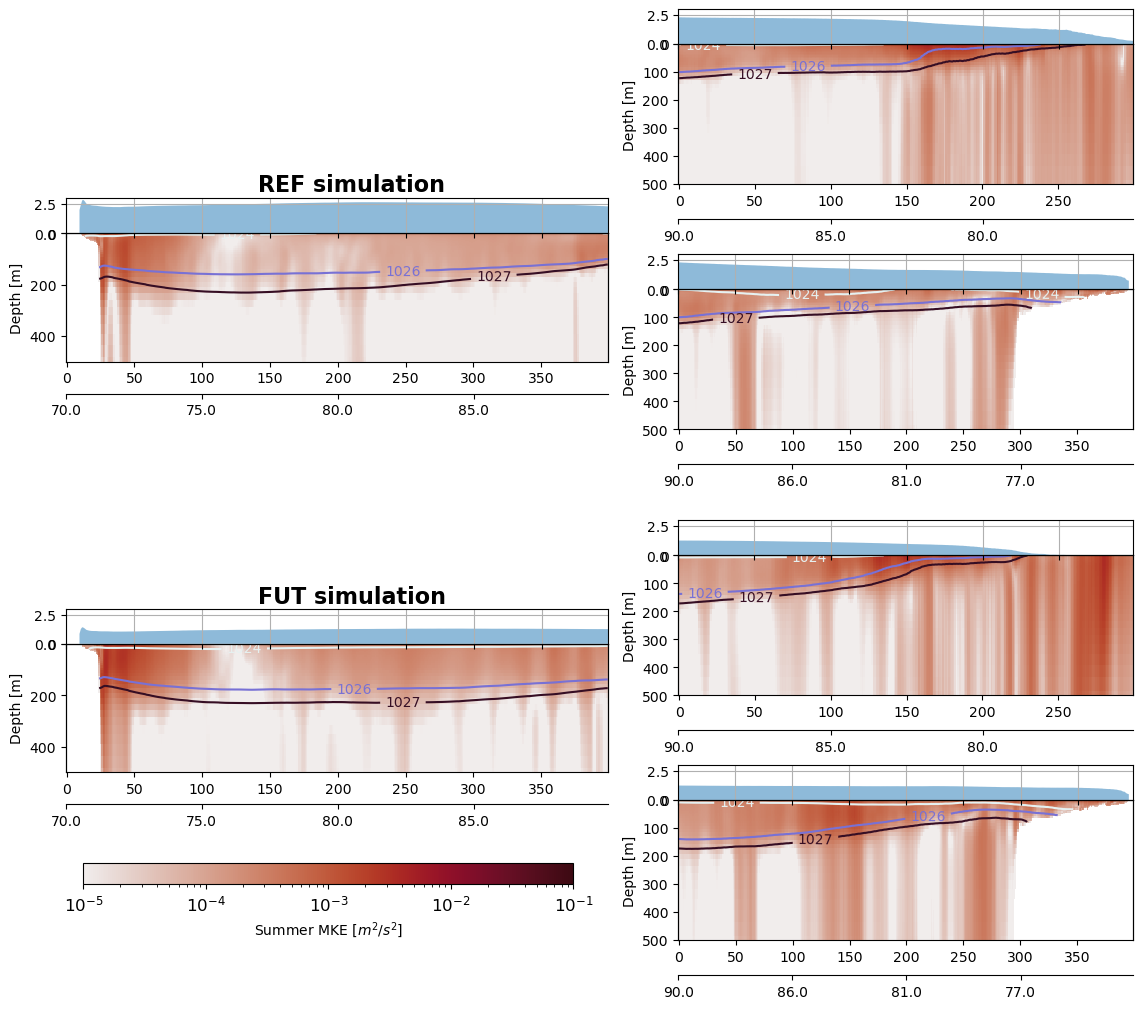

In [77]:
kwargs_plot = { 'cmap':cmo.amp, 'norm':colors.LogNorm(vmin=1e-5, vmax=1e-1), 'add_colorbar':False}

plot_transects(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Summer MKE [$m^2/s^2$]",ylim=(0,500),figsize=(7,7),output="./figures/summer_ICE_MKE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

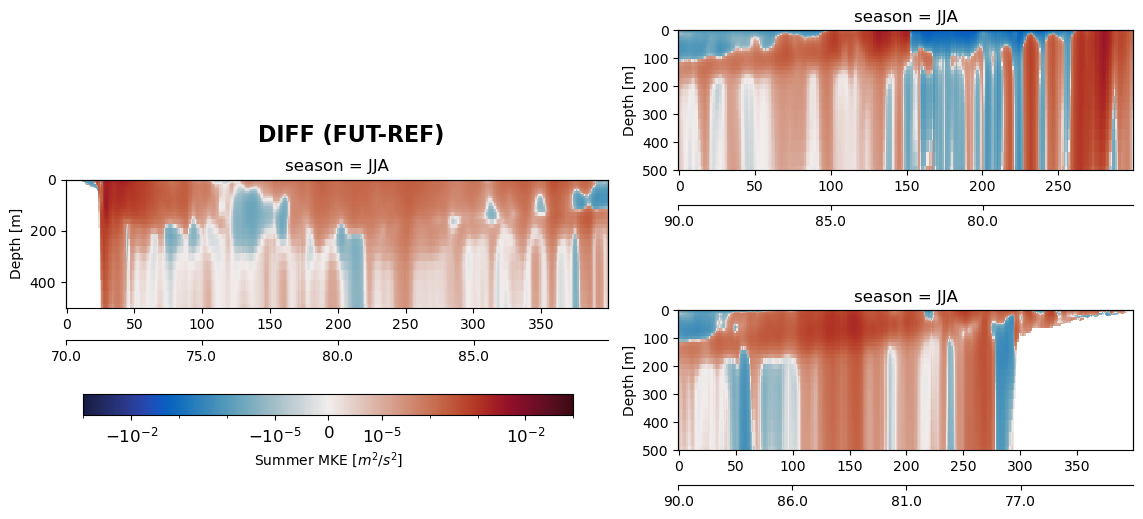

In [78]:
kwargs_plot = { 'cmap':cmo.balance, 'norm':colors.SymLogNorm(linthresh=1e-5, vmin=-1e-1, vmax=1e-1), 'add_colorbar':False}

plot_transects_diff(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Summer MKE [$m^2/s^2$]",ylim=(0,500),figsize=(7,7),output="./figures/summer_diff_ICE_MKE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

In [79]:
ds = {"REF":{"t0":data2plot_REF_EKE_t0.sel(season="DJF"),"t1":data2plot_REF_EKE_t1.sel(season="DJF"),"t2":data2plot_REF_EKE_t2.sel(season="DJF")},
      "FUT":{"t0":data2plot_FUT_EKE_t0.sel(season="DJF"),"t1":data2plot_FUT_EKE_t1.sel(season="DJF"),"t2":data2plot_FUT_EKE_t2.sel(season="DJF")}}

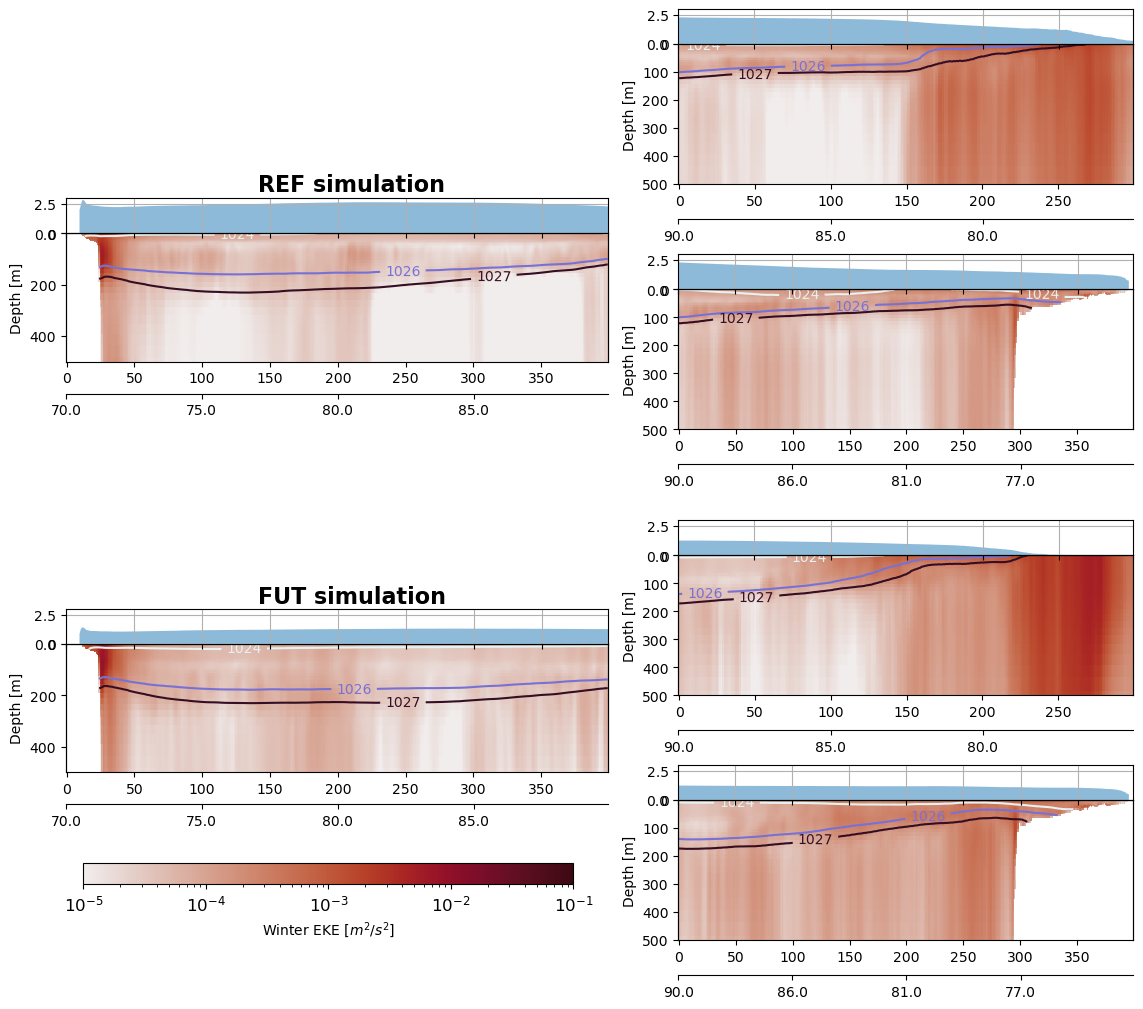

In [80]:
kwargs_plot = { 'cmap':cmo.amp, 'norm':colors.LogNorm(vmin=1e-5, vmax=1e-1), 'add_colorbar':False}

plot_transects(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Winter EKE [$m^2/s^2$]",ylim=(0,500),figsize=(7,7),output="./figures/winter_ICE_EKE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

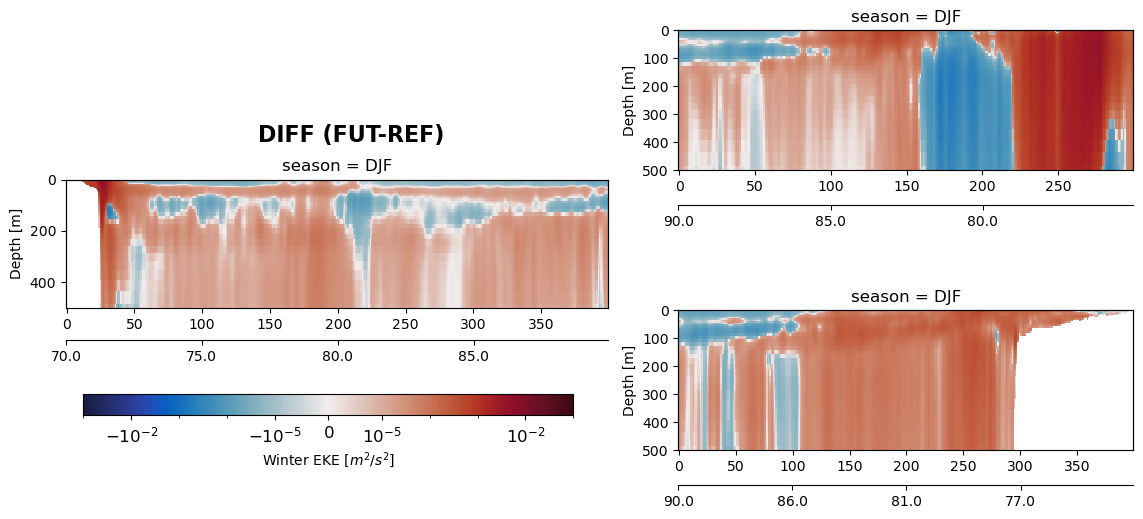

In [81]:
kwargs_plot = { 'cmap':cmo.balance, 'norm':colors.SymLogNorm(linthresh=1e-5, vmin=-1e-1, vmax=1e-1), 'add_colorbar':False}

plot_transects_diff(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Winter EKE [$m^2/s^2$]",ylim=(0,500),figsize=(7,7),output="./figures/winter_diff_ICE_EKE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

In [82]:
ds = {"REF":{"t0":data2plot_REF_EKE_t0.sel(season="JJA"),"t1":data2plot_REF_EKE_t1.sel(season="JJA"),"t2":data2plot_REF_EKE_t2.sel(season="JJA")},
      "FUT":{"t0":data2plot_FUT_EKE_t0.sel(season="JJA"),"t1":data2plot_FUT_EKE_t1.sel(season="JJA"),"t2":data2plot_FUT_EKE_t2.sel(season="JJA")}}

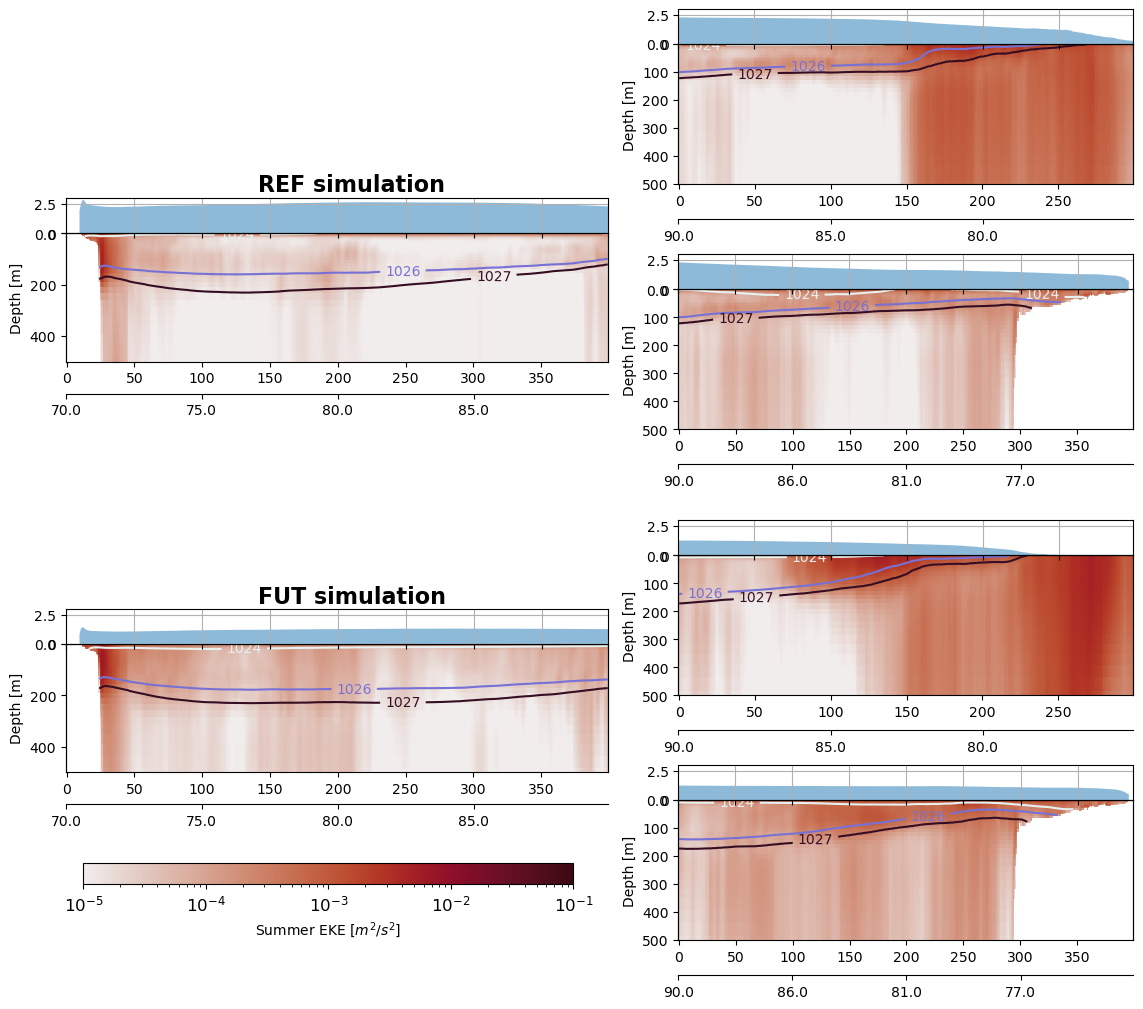

In [83]:
kwargs_plot = { 'cmap':cmo.amp, 'norm':colors.LogNorm(vmin=1e-5, vmax=1e-1), 'add_colorbar':False}

plot_transects(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Summer EKE [$m^2/s^2$]",ylim=(0,500),figsize=(7,7),output="./figures/summer_ICE_EKE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

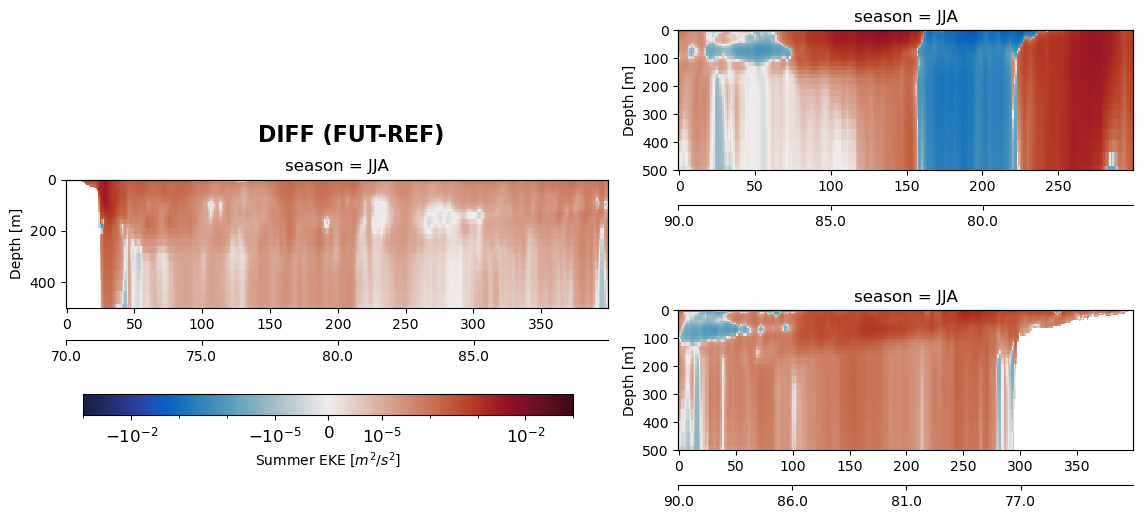

In [84]:
kwargs_plot = { 'cmap':cmo.balance, 'norm':colors.SymLogNorm(linthresh=1e-5, vmin=-1e-1, vmax=1e-1), 'add_colorbar':False}

plot_transects_diff(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Summer EKE [$m^2/s^2$]",ylim=(0,500),figsize=(7,7),output="./figures/summer_diff_ICE_EKE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

# Stratification + ice + density

In [85]:
NSQUARE_REF =xr.open_mfdataset(NSQUARE_data_filesREF, coords="minimal", compat="override", parallel=True, decode_cf=False,concat_dim="time_counter",
                            combine="nested", preprocess=prepro, chunks={"deptht": 5})


NSQUARE_REF = NSQUARE_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [86]:
NSQUARE_FUT = xr.open_mfdataset(NSQUARE_data_filesFUT,  coords="minimal", compat="override", parallel=True, decode_cf=False,concat_dim="time_counter",
                            combine="nested", preprocess=prepro, chunks={"deptht": 5})


NSQUARE_FUT = NSQUARE_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [102]:
# transects_data = extract_transects(transects,NSQUARE_REF,NSQUARE_FUT,'vobn2','/data0/project/drakkar/USERS/jrieck/transects/Nsquare_{0}.nc')

In [106]:
diag_transect_Nsquare_t0 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/Nsquare_transect_0.nc')
diag_transect_Nsquare_t1 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/Nsquare_transect_1.nc')

In [107]:
diag_transect_Nsquare_t0['time_counter'] = diag_transect_EKE_t0.time_counter
diag_transect_Nsquare_t1['time_counter'] = diag_transect_EKE_t1.time_counter

In [108]:
data2plot_REF_nsquare = diag_transect_Nsquare_t0.vobn2_ref_t0.groupby('time_counter.season').mean().compute()
data2plot_FUT_nsquare = diag_transect_Nsquare_t0.vobn2_fut_t0.groupby('time_counter.season').mean().compute()

In [111]:
data2plot_REF_nsquare_t0  = data2plot_REF_nsquare.isel(diag=slice(0,400))
data2plot_FUT_nsquare_t0  = data2plot_FUT_nsquare.isel(diag=slice(0,400))
data2plot_REF_nsquare_t1  = data2plot_REF_nsquare.isel(diag=slice(400,None))
data2plot_FUT_nsquare_t1  = data2plot_FUT_nsquare.isel(diag=slice(400,None))

In [112]:
data2plot_REF_nsquare_t2 = diag_transect_Nsquare_t1.vobn2_ref_t1.groupby('time_counter.season').mean().compute()
data2plot_FUT_nsquare_t2 = diag_transect_Nsquare_t1.vobn2_fut_t1.groupby('time_counter.season').mean().compute()

In [113]:
ds = {"REF":{"t0":data2plot_REF_nsquare_t0.sel(season="DJF"),"t1":data2plot_REF_nsquare_t1.sel(season="DJF"),"t2":data2plot_REF_nsquare_t2.sel(season="DJF")},
      "FUT":{"t0":data2plot_FUT_nsquare_t0.sel(season="DJF"),"t1":data2plot_FUT_nsquare_t1.sel(season="DJF"),"t2":data2plot_FUT_nsquare_t2.sel(season="DJF")}}

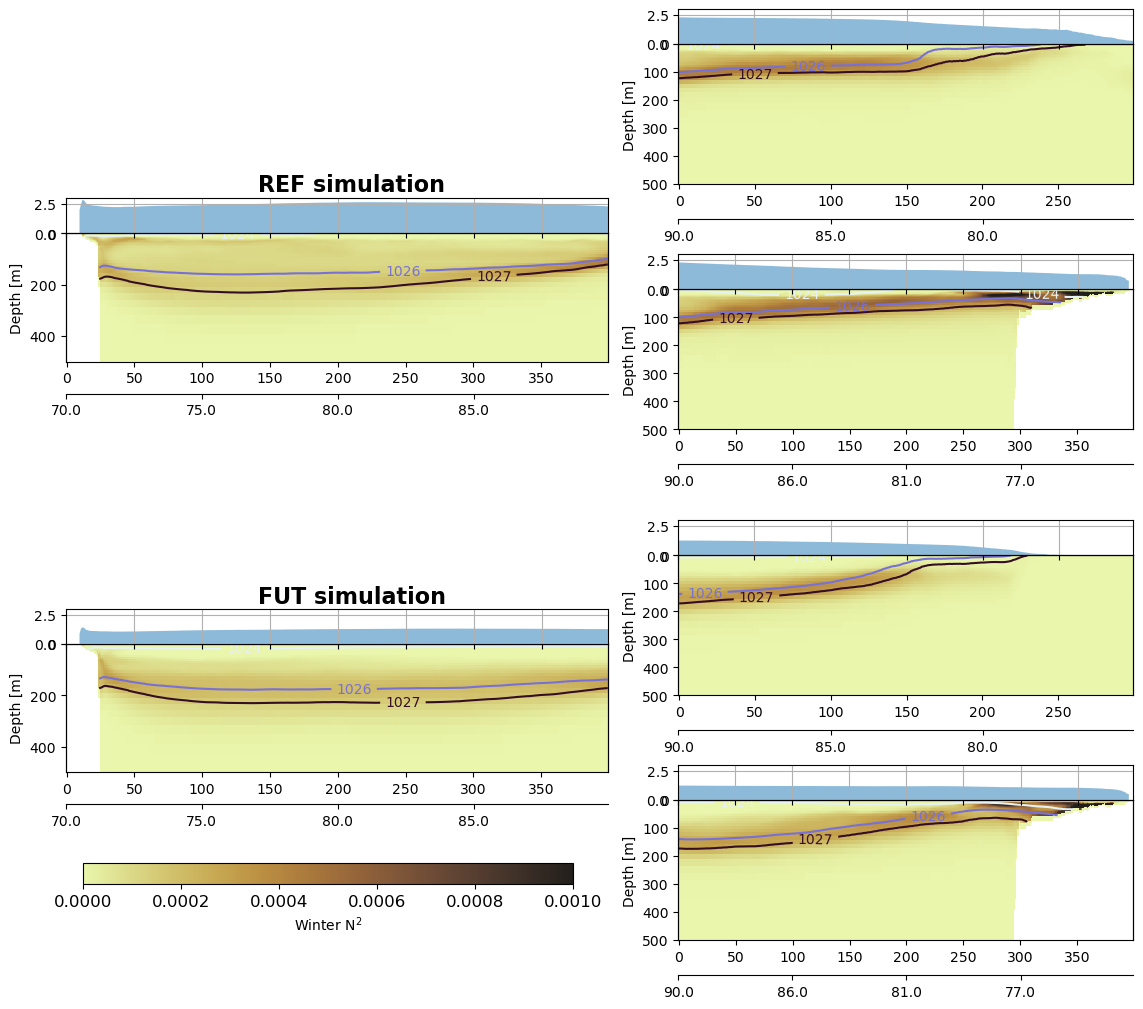

In [114]:
kwargs_plot = { 'cmap':cmo.turbid,'vmin':0,'vmax':1e-3, 'add_colorbar':False}

plot_transects(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Winter N$^2$",ylim=(0,500),figsize=(7,7),output="./figures/winter_ICE_NSQUARE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

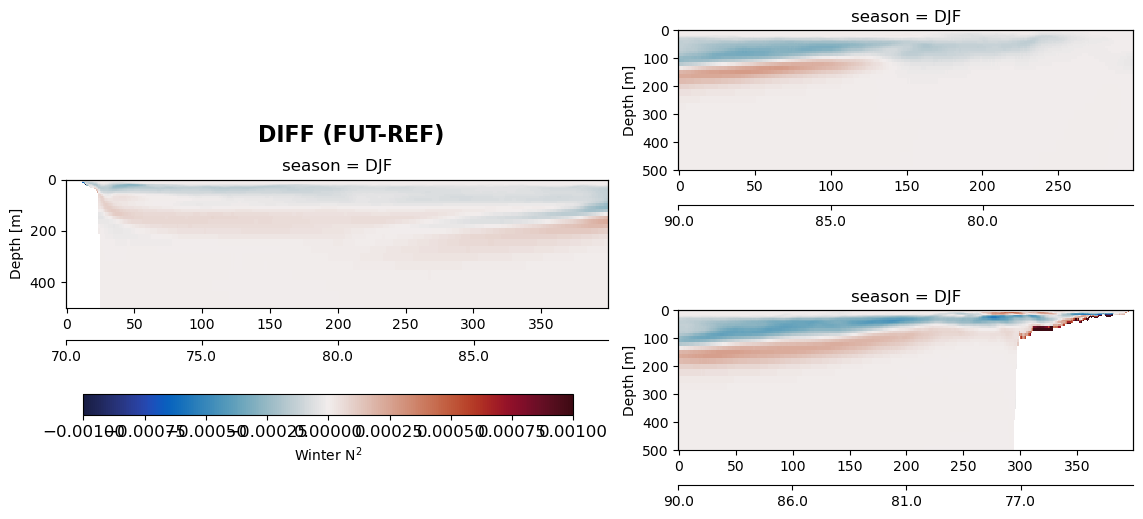

In [115]:
kwargs_plot = { 'cmap':cmo.balance,'vmin':-1e-3,'vmax':1e-3, 'add_colorbar':False}

plot_transects_diff(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Winter N$^2$",ylim=(0,500),figsize=(7,7),output="./figures/winter_diff_ICE_NSQUARE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

In [117]:
ds = {"REF":{"t0":data2plot_REF_nsquare_t0.sel(season="JJA"),"t1":data2plot_REF_nsquare_t1.sel(season="JJA"),"t2":data2plot_REF_nsquare_t2.sel(season="JJA")},
      "FUT":{"t0":data2plot_FUT_nsquare_t0.sel(season="JJA"),"t1":data2plot_FUT_nsquare_t1.sel(season="JJA"),"t2":data2plot_FUT_nsquare_t2.sel(season="JJA")}}

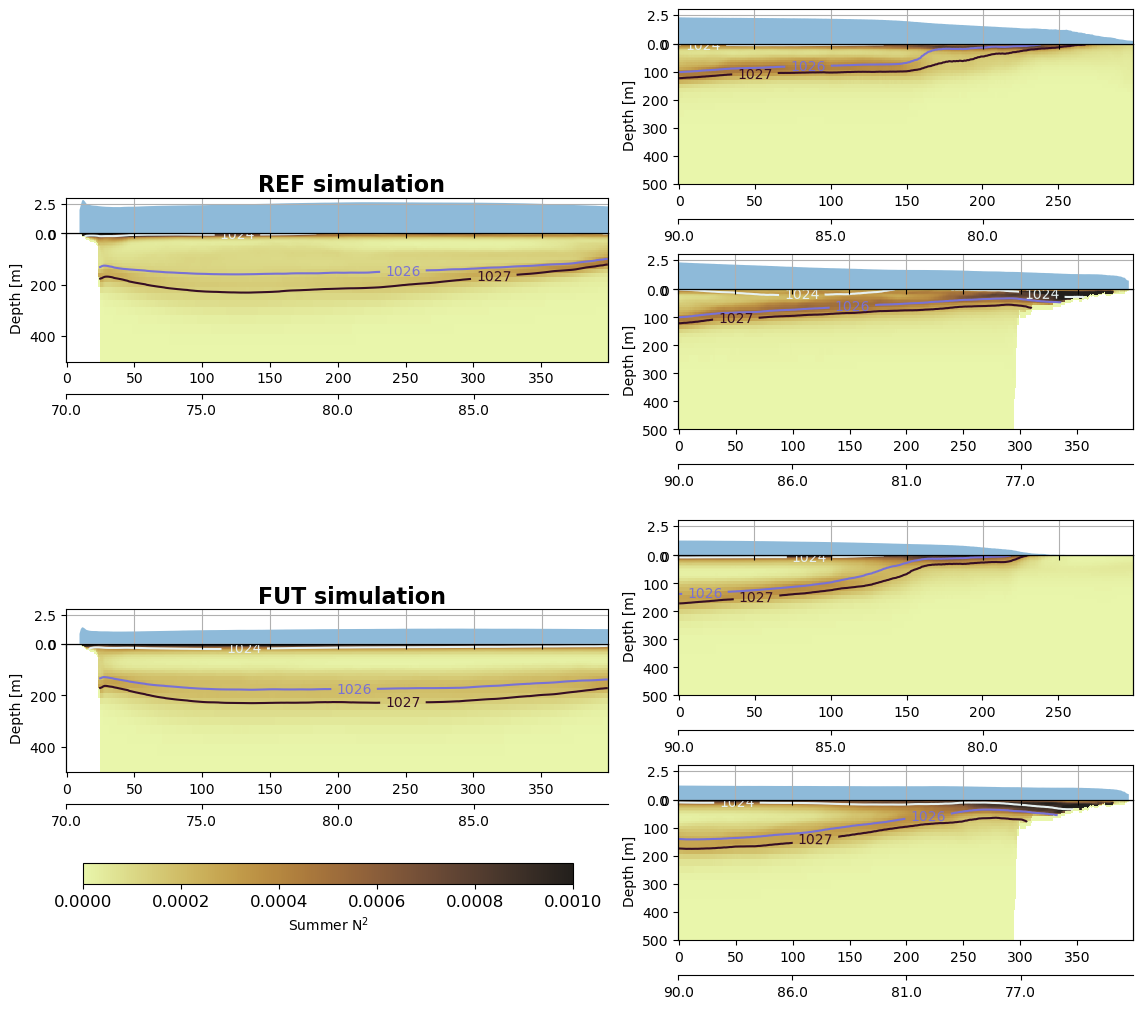

In [118]:
kwargs_plot = { 'cmap':cmo.turbid,'vmin':0,'vmax':1e-3, 'add_colorbar':False}

plot_transects(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Summer N$^2$",ylim=(0,500),figsize=(7,7),output="./figures/summer_ICE_NSQUARE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

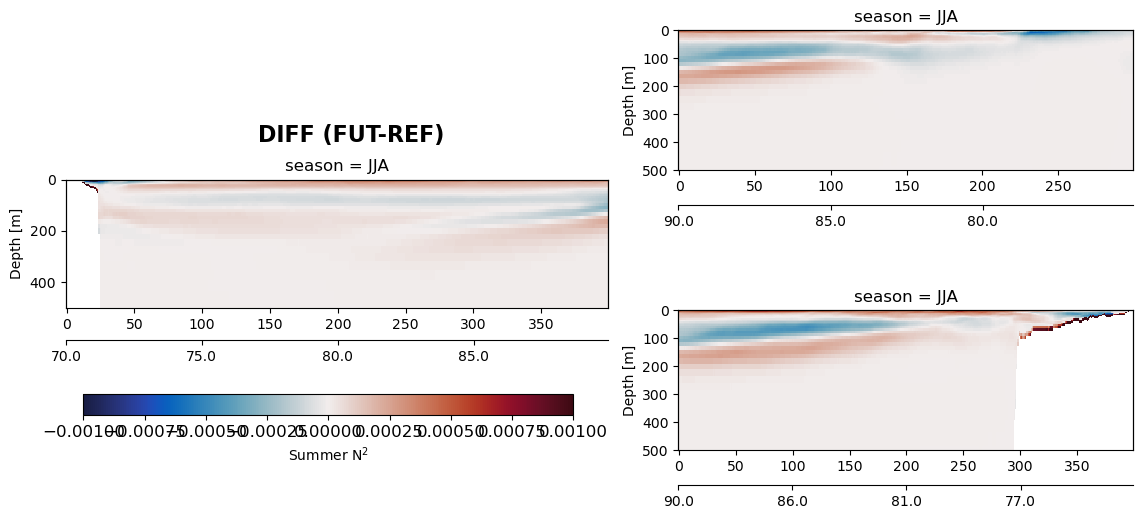

In [119]:
kwargs_plot = { 'cmap':cmo.balance,'vmin':-1e-3,'vmax':1e-3, 'add_colorbar':False}

plot_transects_diff(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Summer N$^2$",ylim=(0,500),figsize=(7,7),output="./figures/summer_diff_ICE_NSQUARE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

# Shear + ice + density

In [120]:
SHEAR_REF =xr.open_mfdataset(SHEAR_data_filesREF, coords="minimal", compat="override", parallel=True, decode_cf=False,concat_dim="time_counter",
                            combine="nested", preprocess=prepro, chunks={"deptht": 5})


SHEAR_REF = SHEAR_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [121]:
SHEAR_FUT = xr.open_mfdataset(SHEAR_data_filesFUT,  coords="minimal", compat="override", parallel=True, decode_cf=False,concat_dim="time_counter",
                            combine="nested", preprocess=prepro, chunks={"deptht": 5})


SHEAR_FUT = SHEAR_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [123]:
# transects_data = extract_transects(transects,SHEAR_REF,SHEAR_FUT,'vovshear','/data0/project/drakkar/USERS/jrieck/transects/Shear_{0}.nc')

In [124]:
diag_transect_Shear_t0 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/Shear_transect_0.nc')
diag_transect_Shear_t1 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/Shear_transect_1.nc')

In [127]:
diag_transect_Shear_t0['time_counter'] = diag_transect_EKE_t0.time_counter
diag_transect_Shear_t1['time_counter'] = diag_transect_EKE_t1.time_counter

In [128]:
data2plot_REF_nsquare = diag_transect_Shear_t0.vovshear_ref_t0.groupby('time_counter.season').mean().compute()
data2plot_FUT_nsquare = diag_transect_Shear_t0.vovshear_fut_t0.groupby('time_counter.season').mean().compute()

In [129]:
data2plot_REF_Shear_t0  = data2plot_REF_nsquare.isel(diag=slice(0,400))
data2plot_FUT_Shear_t0  = data2plot_FUT_nsquare.isel(diag=slice(0,400))
data2plot_REF_Shear_t1  = data2plot_REF_nsquare.isel(diag=slice(400,None))
data2plot_FUT_Shear_t1  = data2plot_FUT_nsquare.isel(diag=slice(400,None))

In [130]:
data2plot_REF_Shear_t2 = diag_transect_Shear_t1.vovshear_ref_t1.groupby('time_counter.season').mean().compute()
data2plot_FUT_Shear_t2 = diag_transect_Shear_t1.vovshear_fut_t1.groupby('time_counter.season').mean().compute()

In [131]:
ds = {"REF":{"t0":data2plot_REF_Shear_t0.sel(season="DJF"),"t1":data2plot_REF_Shear_t1.sel(season="DJF"),"t2":data2plot_REF_Shear_t2.sel(season="DJF")},
      "FUT":{"t0":data2plot_FUT_Shear_t0.sel(season="DJF"),"t1":data2plot_FUT_Shear_t1.sel(season="DJF"),"t2":data2plot_FUT_Shear_t2.sel(season="DJF")}}

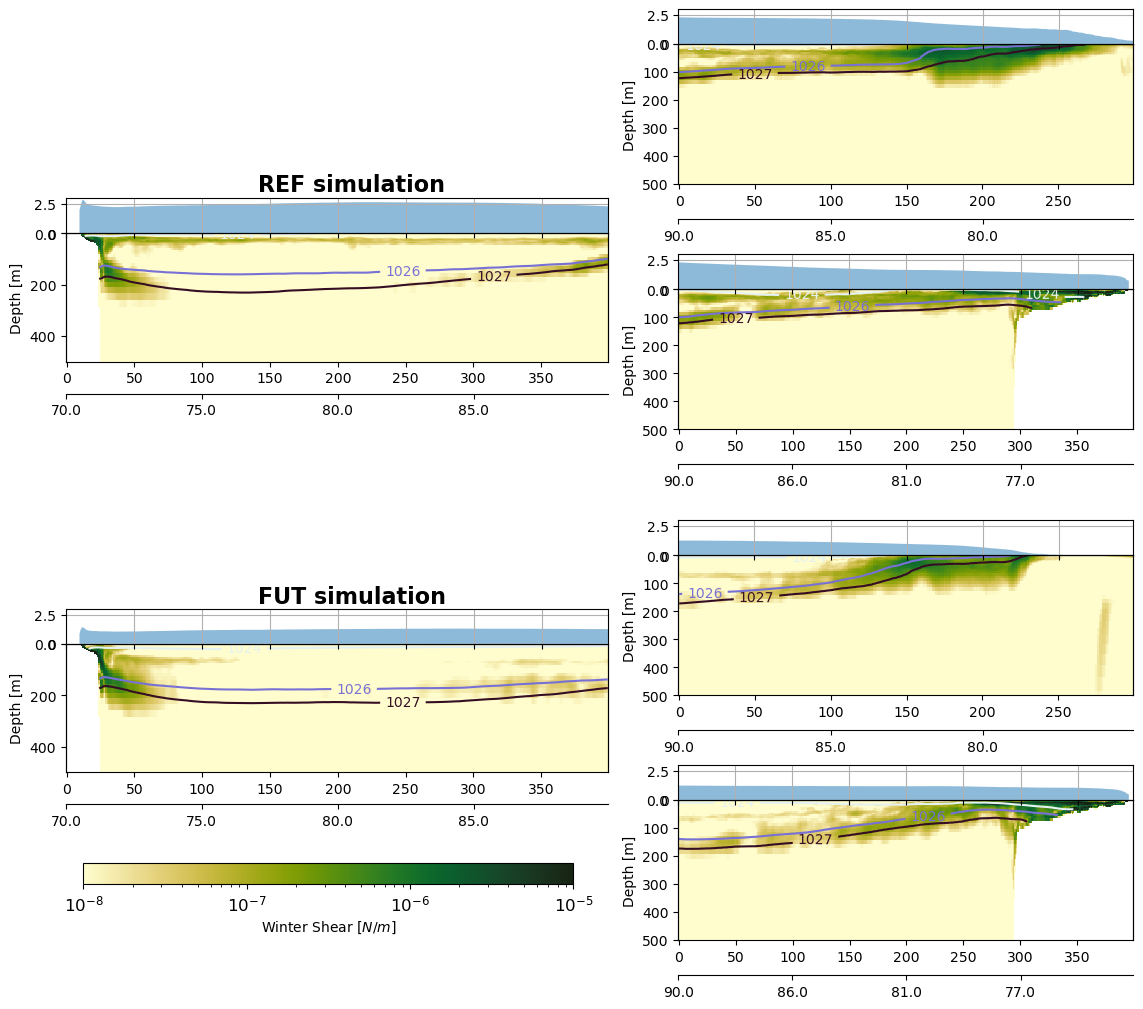

In [132]:
kwargs_plot = { 'cmap':cmo.speed, 'norm':colors.LogNorm(vmin=1e-8, vmax=1e-5), 'add_colorbar':False}

plot_transects(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Winter Shear [$N/m$]",ylim=(0,500),figsize=(7,7),output="./figures/winter_ICE_NSQUARE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

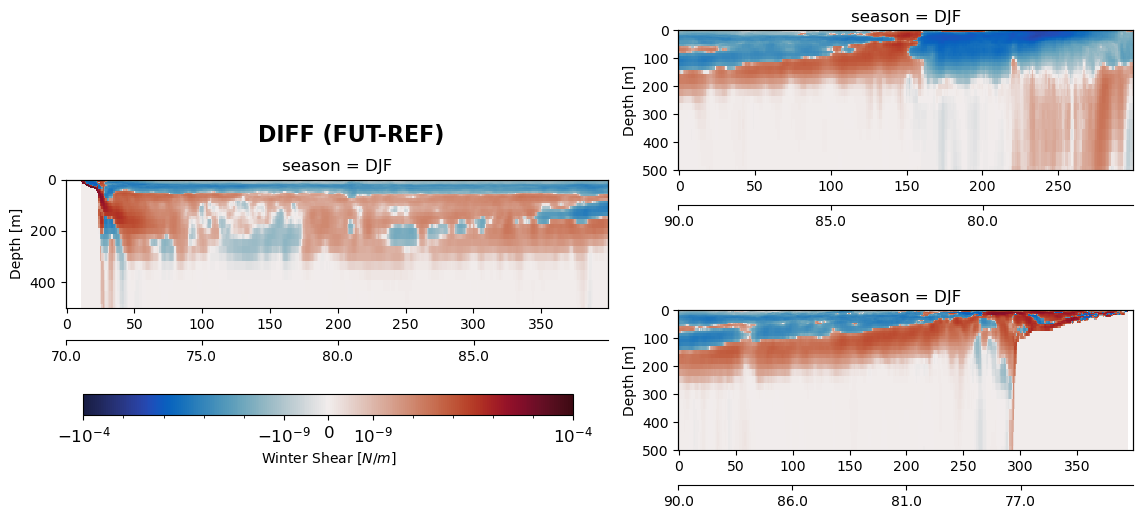

In [133]:
kwargs_plot = { 'cmap':cmo.balance, 'norm':colors.SymLogNorm(linthresh=1e-9, vmin=-1e-4, vmax=1e-4), 'add_colorbar':False}

plot_transects_diff(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Winter Shear [$N/m$]",ylim=(0,500),figsize=(7,7),output="./figures/winter_diff_ICE_NSQUARE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

In [134]:
ds = {"REF":{"t0":data2plot_REF_Shear_t0.sel(season="JJA"),"t1":data2plot_REF_Shear_t1.sel(season="JJA"),"t2":data2plot_REF_Shear_t2.sel(season="JJA")},
      "FUT":{"t0":data2plot_FUT_Shear_t0.sel(season="JJA"),"t1":data2plot_FUT_Shear_t1.sel(season="JJA"),"t2":data2plot_FUT_Shear_t2.sel(season="JJA")}}

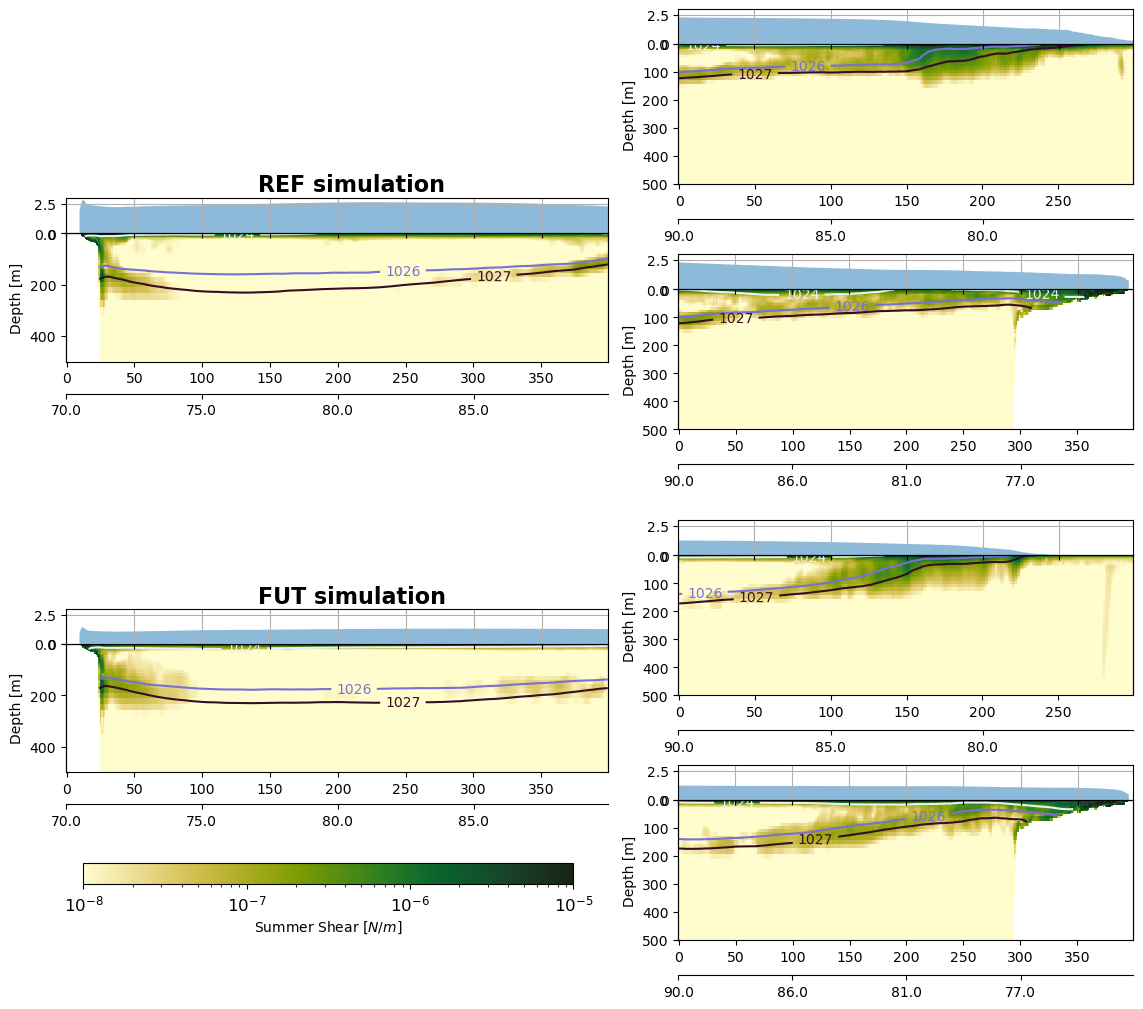

In [135]:
kwargs_plot = { 'cmap':cmo.speed, 'norm':colors.LogNorm(vmin=1e-8, vmax=1e-5), 'add_colorbar':False}

plot_transects(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Summer Shear [$N/m$]",ylim=(0,500),figsize=(7,7),output="./figures/summer_ICE_NSQUARE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

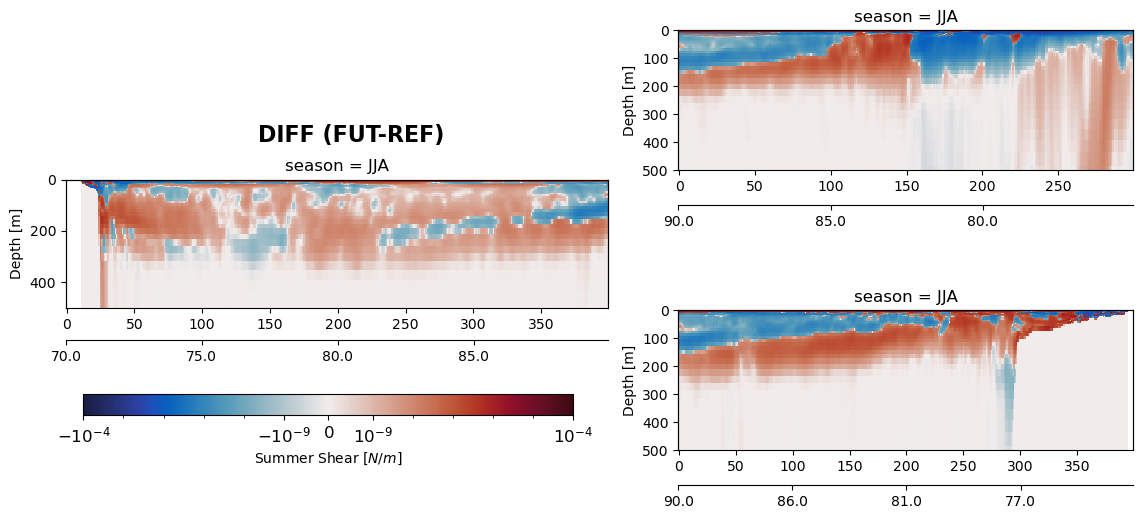

In [136]:
kwargs_plot = { 'cmap':cmo.balance, 'norm':colors.SymLogNorm(linthresh=1e-9, vmin=-1e-4, vmax=1e-4), 'add_colorbar':False}

plot_transects_diff(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="Summer Shear [$N/m$]",ylim=(0,500),figsize=(7,7),output="./figures/summer_diff_ICE_NSQUARE_REF_FUT.pdf", kwargs_plot = kwargs_plot)

# PV + ice + density

In [266]:
PV_REF = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-PVORT/transect_1.nc')
PV_FUT = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-PVORT/transect_1.nc')

In [267]:
PV_REF_t2 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-PVORT/transect_2.nc')
PV_FUT_t2 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-PVORT/transect_2.nc')

In [268]:
data2plot_REF_PV = PV_REF.vototvor
data2plot_FUT_PV = PV_FUT.vototvor
data2plot_REF_PV_t2 = PV_REF_t2.vototvor
data2plot_FUT_PV_t2 = PV_FUT_t2.vototvor

In [280]:
data2plot_REF_PV_t0  = data2plot_REF_PV.isel(diag=slice(0,400))
data2plot_FUT_PV_t0  = data2plot_FUT_PV.isel(diag=slice(0,400))
data2plot_REF_PV_t1  = data2plot_REF_PV.isel(diag=slice(400,None))
data2plot_FUT_PV_t1  = data2plot_FUT_PV.isel(diag=slice(400,None))

In [281]:
ds = {"REF":{"t0":data2plot_REF_PV_t0,"t1":data2plot_REF_PV_t1,"t2":data2plot_REF_PV_t2},
      "FUT":{"t0":data2plot_FUT_PV_t0,"t1":data2plot_FUT_PV_t1,"t2":data2plot_FUT_PV_t2}}

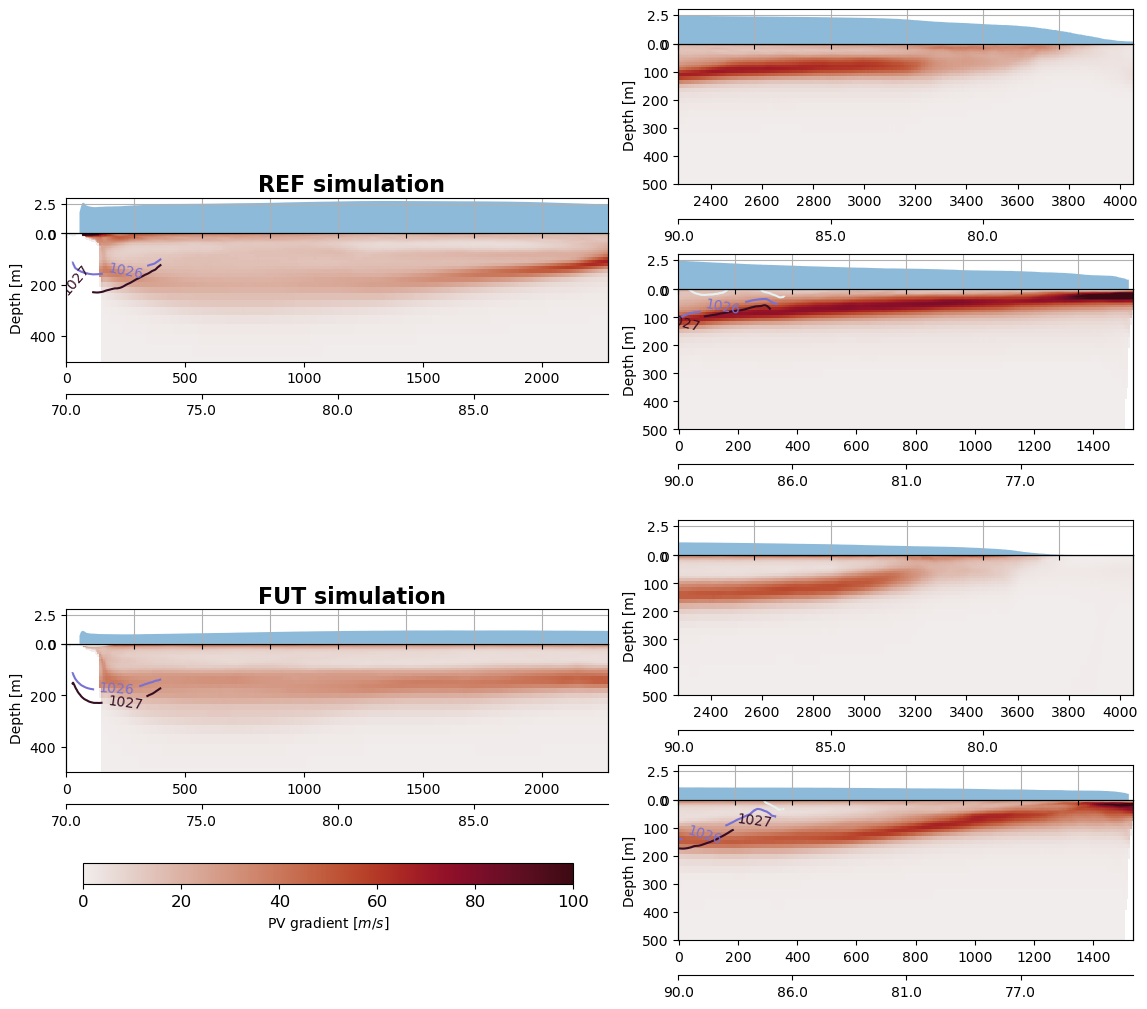

In [282]:
kwargs_plot = {'cmap':cmo.amp,'vmin':-0,'vmax':100, 'add_colorbar':False}

plot_transects(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="PV gradient [$m/s$]",ylim=(0,500),figsize=(7,7),output="./figures/ICE_PV_REF_FUT.pdf", kwargs_plot = kwargs_plot)

In [284]:
# kwargs_plot = {'cmap':cmo.balance,'vmin':-10,'vmax':10,'levels':6, 'add_colorbar':False}

# plot_transects_diff(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,contourf=True,varname="PV gradient [$m/s$]",ylim=(0,500),figsize=(7,7),output="./figures/diff_ICE_PV_REF_FUT_contourf.pdf", kwargs_plot = kwargs_plot)

# PV grad + ice + density

In [285]:
PV_REF = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-PVORT/transect_1.nc')
PV_FUT = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-PVORT/transect_1.nc')

In [286]:
PV_REF_t2 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-PVORT/transect_2.nc')
PV_FUT_t2 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-PVORT/transect_2.nc')

In [300]:
data2plot_REF_PV = PV_REF.vototvor.differentiate('diag').drop('diag').interpolate_na("diag")
data2plot_FUT_PV = PV_FUT.vototvor.differentiate('diag').drop('diag').interpolate_na("diag")
data2plot_REF_PV_t2 = PV_REF_t2.vototvor.differentiate('diag').drop('diag').interpolate_na("diag")
data2plot_FUT_PV_t2 = PV_FUT_t2.vototvor.differentiate('diag').drop('diag').interpolate_na("diag")

/home/jmartine/.miniconda3/envs/py_gcm/lib/python3.10/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/jmartine/.miniconda3/envs/py_gcm/lib/python3.10/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/jmartine/.miniconda3/envs/py_gcm/lib/python3.10/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/jmartine/.miniconda3/envs/py_gcm/lib/python3.10/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/tmp/ipykernel_192854/1375265826.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data2plot_REF_PV = PV_REF.vototvor.differentiate('diag').drop('diag').interpol

In [302]:
data2plot_REF_PV_t0  = data2plot_REF_PV.isel(diag=slice(0,400))
data2plot_FUT_PV_t0  = data2plot_FUT_PV.isel(diag=slice(0,400))
data2plot_REF_PV_t1  = data2plot_REF_PV.isel(diag=slice(400,None))
data2plot_FUT_PV_t1  = data2plot_FUT_PV.isel(diag=slice(400,None))

In [303]:
ds = {"REF":{"t0":data2plot_REF_PV_t0,"t1":data2plot_REF_PV_t1,"t2":data2plot_REF_PV_t2},
      "FUT":{"t0":data2plot_FUT_PV_t0,"t1":data2plot_FUT_PV_t1,"t2":data2plot_FUT_PV_t2}}

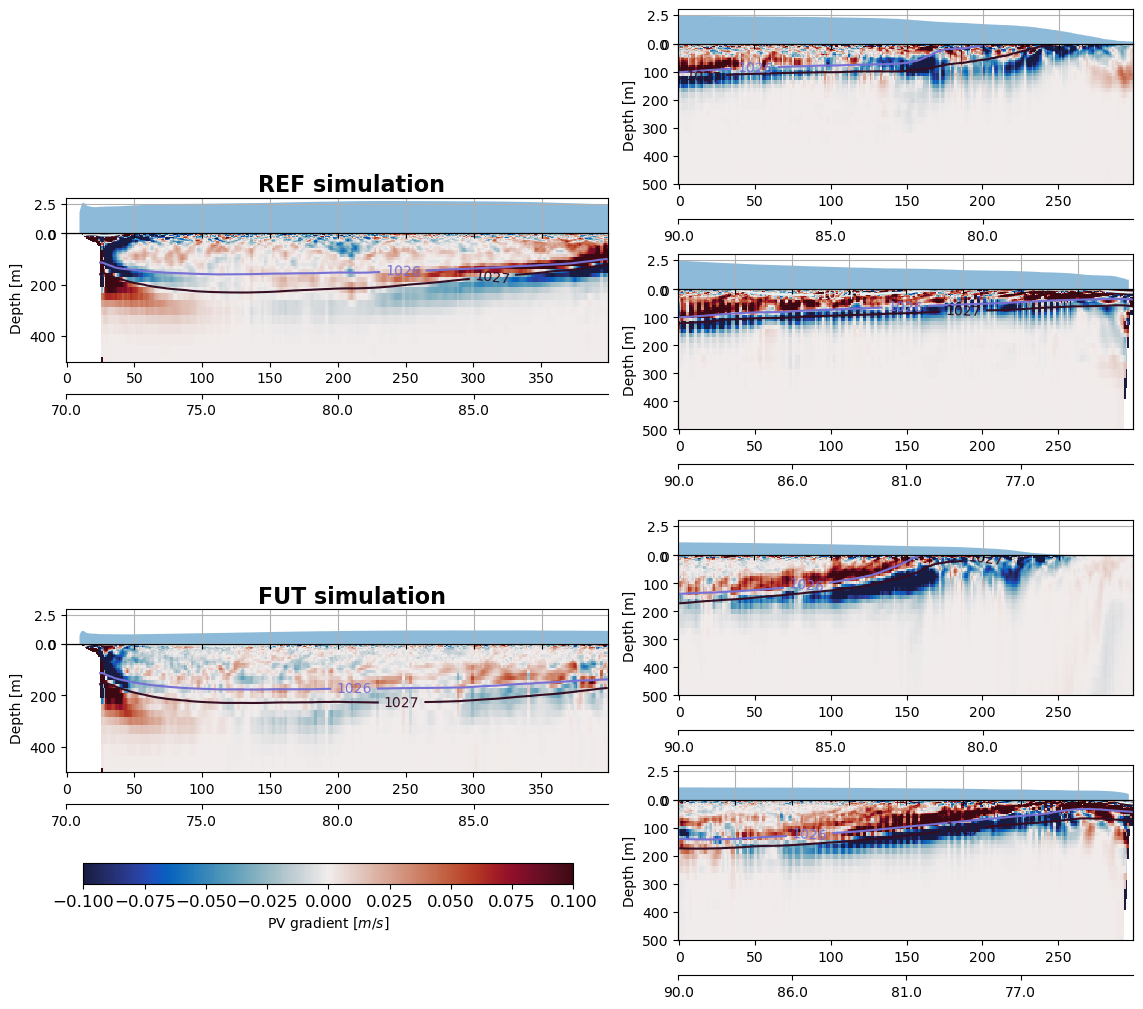

In [304]:
kwargs_plot = {'cmap':cmo.balance,'vmin':-0.1,'vmax':0.1, 'add_colorbar':False}

plot_transects(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="PV gradient [$m/s$]",ylim=(0,500),figsize=(7,7),output="./figures/ICE_grad_PV_REF_FUT.pdf", kwargs_plot = kwargs_plot)

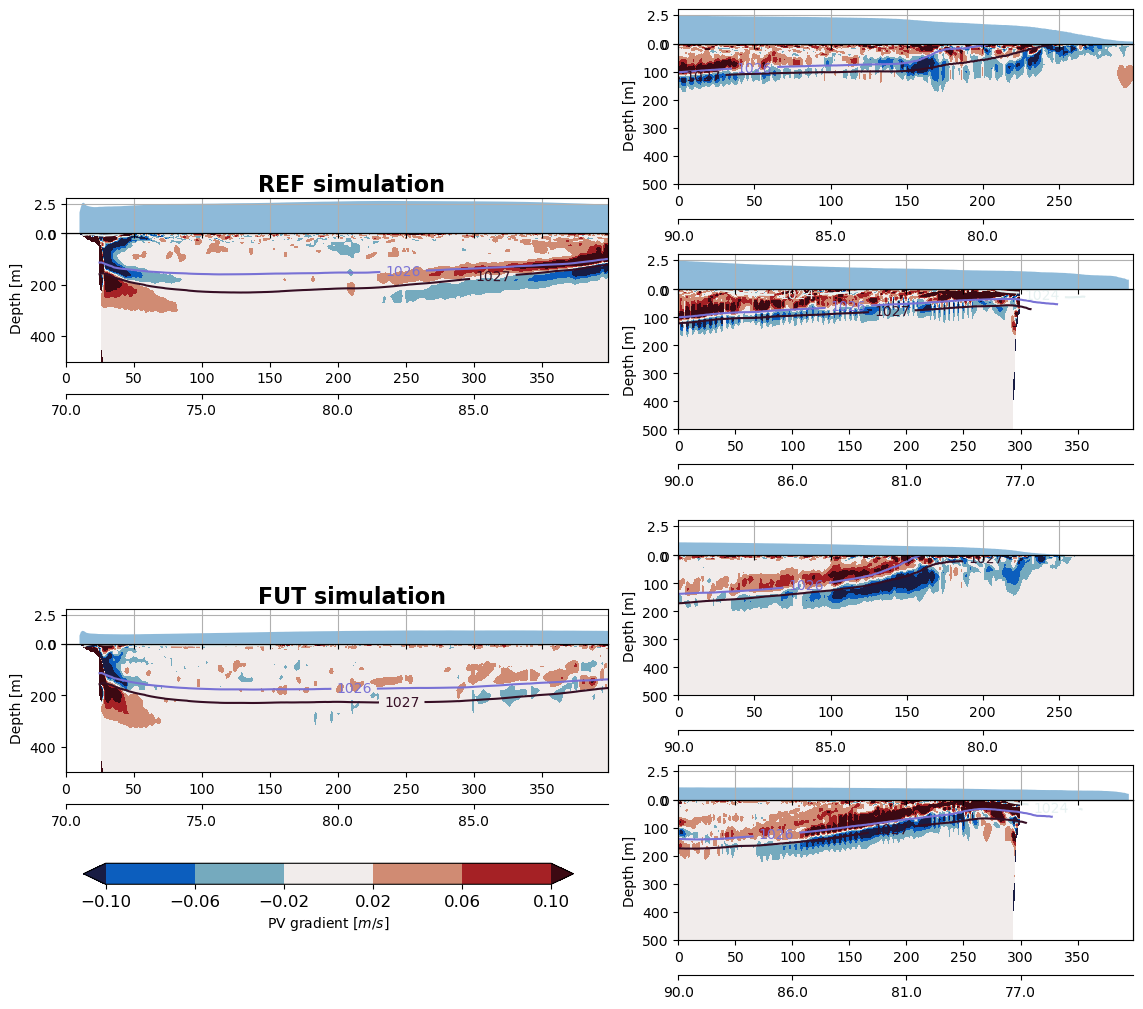

In [305]:
kwargs_plot = {'cmap':cmo.balance,'vmin':-0.1,'vmax':0.1,'levels':6, 'add_colorbar':False}

plot_transects(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,contourf=True,varname="PV gradient [$m/s$]",ylim=(0,500),figsize=(7,7),output="./figures/ICE_grad_PV_REF_FUT_contourf.pdf", kwargs_plot = kwargs_plot)

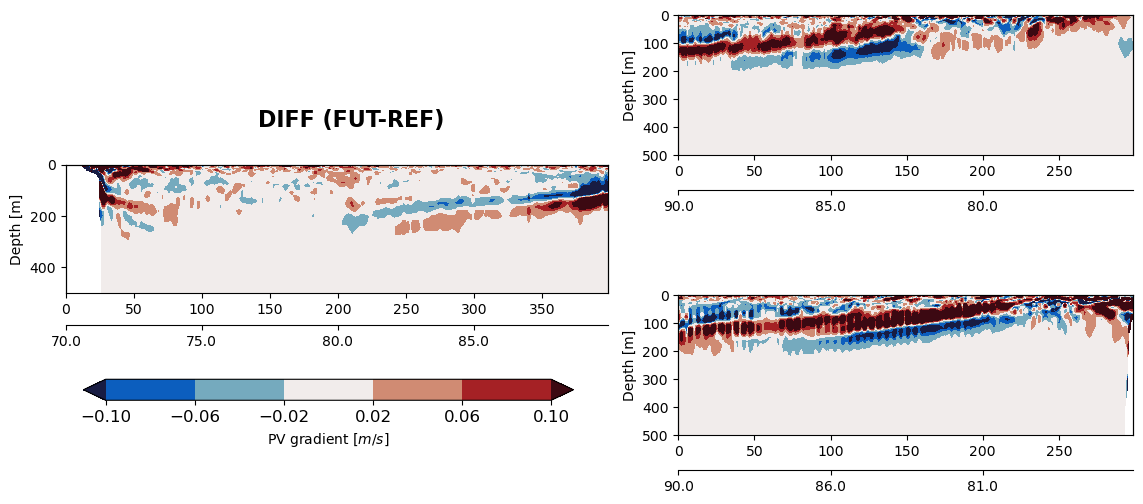

In [306]:
kwargs_plot = {'cmap':cmo.balance,'vmin':-0.1,'vmax':0.1,'levels':6, 'add_colorbar':False}

plot_transects_diff(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,contourf=True,varname="PV gradient [$m/s$]",ylim=(0,500),figsize=(7,7),output="./figures/diff_grad_ICE_PV_REF_FUT_contourf.pdf", kwargs_plot = kwargs_plot)

# W'B'

In [307]:
mean_WpBp_REF = xr.open_dataset("/data0/project/drakkar/USERS/jrieck/wp_bp_REF_clim.nc")
mean_WpBp_FUT = xr.open_dataset("/data0/project/drakkar/USERS/jrieck/wp_bp_FUT_clim.nc")

In [308]:
mean_WpBp_REF = mean_WpBp_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})
mean_WpBp_FUT = mean_WpBp_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [310]:
transects_data = extract_transects(transects,mean_WpBp_REF,mean_WpBp_FUT,'__xarray_dataarray_variable__','/data0/project/drakkar/USERS/jrieck/transects/Wp_Bp_{0}.nc')

Storing data


In [312]:
diag_transect_wp_bp_t0 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/Wp_Bp_transect_0.nc')
diag_transect_wp_bp_t1 = xr.open_dataset('/data0/project/drakkar/USERS/jrieck/transects/Wp_Bp_transect_1.nc')

In [340]:
data2plot_REF_wp_bp = diag_transect_wp_bp_t0.__xarray_dataarray_variable___ref_t0
data2plot_FUT_wp_bp = diag_transect_wp_bp_t0.__xarray_dataarray_variable___fut_t0

In [341]:
data2plot_REF_wp_bp_t0  = data2plot_REF_wp_bp.isel(diag=slice(0,400))
data2plot_FUT_wp_bp_t0  = data2plot_FUT_wp_bp.isel(diag=slice(0,400))
data2plot_REF_wp_bp_t1  = data2plot_REF_wp_bp.isel(diag=slice(400,None))
data2plot_FUT_wp_bp_t1  = data2plot_FUT_wp_bp.isel(diag=slice(400,None))

In [342]:
data2plot_REF_wp_bp_t2  = diag_transect_wp_bp_t1.__xarray_dataarray_variable___ref_t1
data2plot_FUT_wp_bp_t2  = diag_transect_wp_bp_t1.__xarray_dataarray_variable___fut_t1

In [343]:
ds = {"REF":{"t0":data2plot_REF_wp_bp_t0,"t1":data2plot_REF_wp_bp_t1,"t2":data2plot_REF_wp_bp_t2},
      "FUT":{"t0":data2plot_FUT_wp_bp_t0,"t1":data2plot_FUT_wp_bp_t1,"t2":data2plot_FUT_wp_bp_t2}}

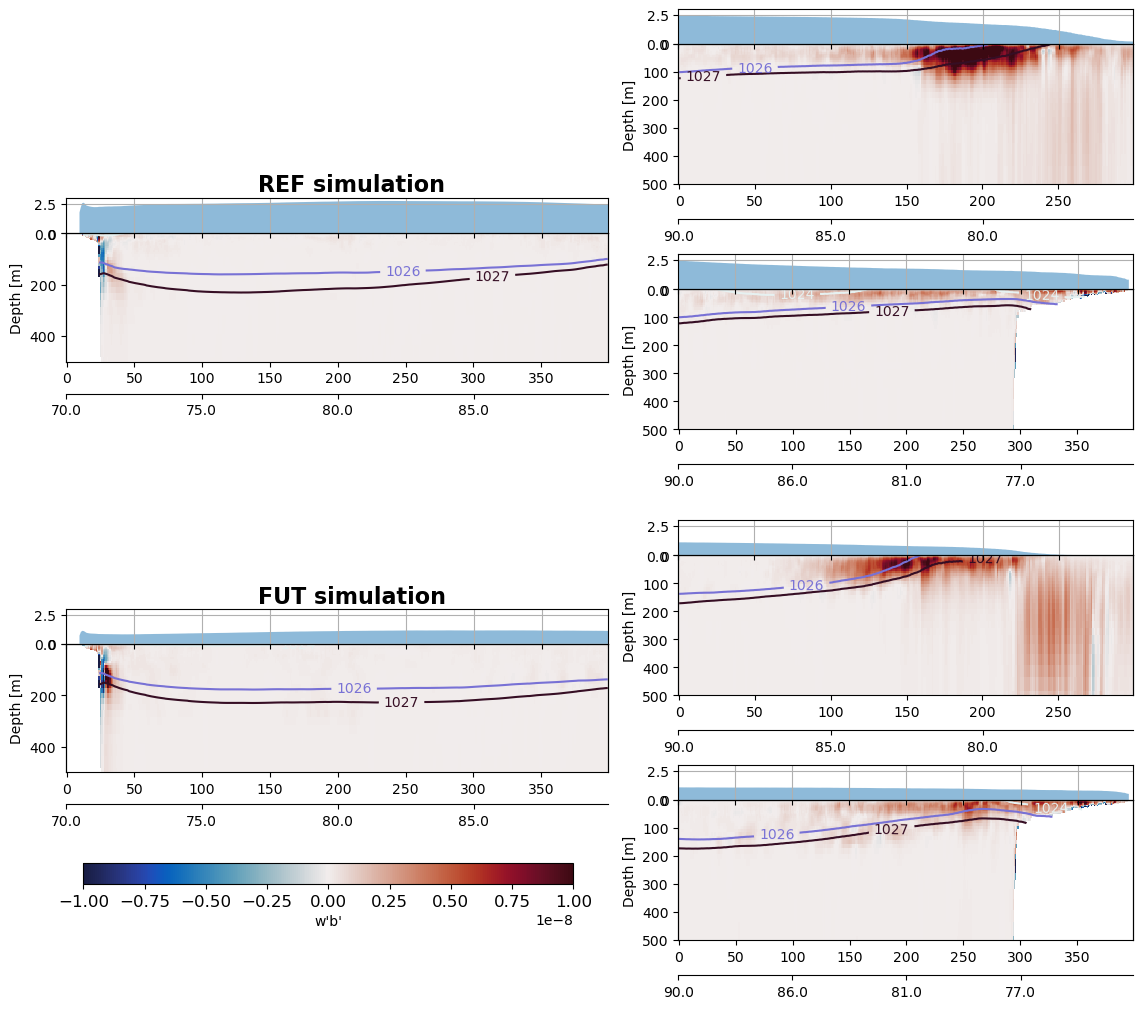

In [362]:
kwargs_plot = {'cmap':cmo.balance,'vmin': -1e-8, 'vmax': 1e-8, 'add_colorbar':False}

plot_transects(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="w'b'",ylim=(0,500),figsize=(7,7),output="./figures/ICE_wp_bp_REF_FUT.pdf", kwargs_plot = kwargs_plot)

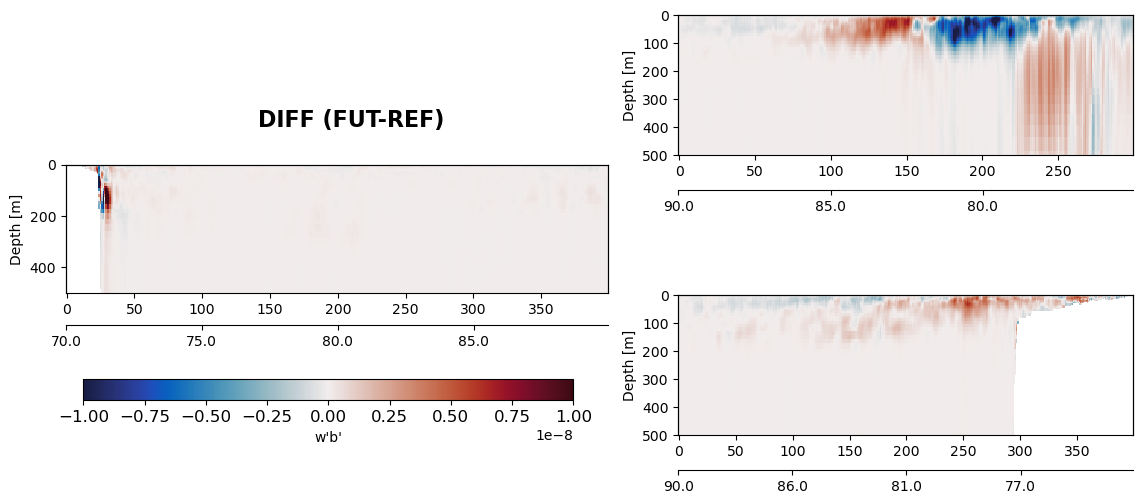

In [363]:
kwargs_plot = {'cmap':cmo.balance,'vmin': -1e-8, 'vmax': 1e-8, 'add_colorbar':False}

plot_transects_diff(ds=ds,ds_cf=ds_cf,ds_ice=ds_ice,contour=True,varname="w'b'",ylim=(0,500),figsize=(7,7),output="./figures/diff_ICE_wp_bp_REF_FUT.pdf", kwargs_plot = kwargs_plot)
